<a href="https://colab.research.google.com/github/pach28/Forecasting-Sticker-Sales/blob/main/forecasting_sticker_sales_NaN_analysis_%26_feat_treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
kagglehub.login()

In [ ]:
import os

# Download the competition dataset
playground_series_s5e1_path = kagglehub.competition_download('playground-series-s5e1')

# Extract the directory name from the downloaded path
dataset_dir = os.path.splitext(playground_series_s5e1_path)[0]

# Construct the correct paths to the train.csv and test.csv files
train_csv_path = os.path.join(dataset_dir, 'train.csv')
test_csv_path = os.path.join(dataset_dir, 'test.csv')

# Read the CSV files using the correct paths
train = pd.read_csv(train_csv_path, parse_dates=["date"])
test = pd.read_csv(test_csv_path, parse_dates=["date"])

#para paises se codificara en variables categoricas por one-hot encoding

In [ ]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [ ]:
import pandas as pd
import requests

def get_gdp_per_capita(countries, start_year, end_year):
    """
    Obtiene los datos del PIB per cápita de los países especificados desde la API del Banco Mundial.

    Args:
        countries: Una lista con los códigos de los países.
        start_year: Año de inicio.
        end_year: Año final.

    Returns:
        Un DataFrame de pandas con los datos del PIB per cápita.
    """

    # Construir la URL base de la API
    base_url = "https://api.worldbank.org/v2/country/"

    # Crear una lista de URLs para cada país
    urls = [f"{base_url}{country}/indicator/NY.GDP.PCAP.CD?date={start_year}:{end_year}&format=json" for country in countries]

    # Hacer las solicitudes a la API y crear un DataFrame para cada país
    dfs = []
    for url in urls:
        response = requests.get(url)
        data = response.json()

        # Check if the response is valid and contains data
        if response.status_code == 200 and len(data) > 1 and isinstance(data[1], list) and len(data[1]) > 0:
            df = pd.DataFrame(data[1])

            # Ensure 'country' and 'date' contain scalar values before pivoting
            # Example: If 'country' is a dictionary, extract a specific key
            if isinstance(df['country'].iloc[0], dict):
                df['country'] = df['country'].apply(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)
            # Similarly, handle 'date' if necessary

            df = df.pivot_table(index='country', columns='date', values='value')
            dfs.append(df)
        else:
            print(f"Warning: Request for {url} failed or returned unexpected data.")

    # Concatenar los DataFrames
    df_final = pd.concat(dfs, axis=0)

    return df_final
countries = ['CAN', 'FIN', 'ITA','KEN','NOR','SGP']
df_pib = get_gdp_per_capita(countries, 2010, 2020)

In [ ]:
df_pib.head()

date             2010           2011           2012           2013  \
country                                                              
Canada   47560.666601   52223.858840   52670.344734   52638.118724   
Finland  46506.291902   51060.324259   47551.674084   49691.014520   
Italy    36184.711870   38851.388134   35235.798906   35747.707953   
Kenya     1091.518731    1096.144998    1285.005362    1370.878852   
Norway   88163.208593  101221.813477  102175.919298  103553.840134   

date             2014          2015          2016          2017          2018  \
country                                                                         
Canada   50960.843117  43594.194105  42314.061582  45129.628117  46539.176157   
Finland  50073.776082  42560.345677  43451.256244  46085.017474  49654.249704   
Italy    35750.719750  30387.129319  31126.324695  32554.146685  34746.344139   
Kenya     1482.815663   1489.119598   1554.126103   1667.484472   1836.452755   
Norway   97666.695184  74809.965805  70867.360997  76131.838403  82792.842711   

date             2019          2020  
country                              
Canada   46352.869345  43537.839299  
Finland  48358.180777  48828.684686  
Italy    33812.788725  32091.486662  
Kenya     1960.408089   1927.664590  
Norway   76430.588947  68340.018103

In [ ]:
#agregar por año el gdp per capita de los distintos paises a train y a test
# Supongamos que tienes un DataFrame llamado 'df' con columnas 'pais' y 'fecha'
# y un DataFrame 'df_pib' con el PIB per cápita por país y año (obtenido en el paso anterior)

# Función para agregar el PIB per cápita al DataFrame principal
def agregar_pib(df, df_pib):
    # Crear una nueva columna en df para almacenar el PIB per cápita
    df['PIB_per_capita'] = np.nan

    # Iterar sobre cada fila del DataFrame principal
    for index, row in df.iterrows():
        pais = row['country']
        anio = row['date'].year
        # Buscar el PIB per cápita correspondiente en el DataFrame de PIB
        pib = df_pib.loc[pais, str(anio)]
        # Asignar el PIB per cápita a la fila correspondiente en el DataFrame principal
        df.at[index, 'PIB_per_capita'] = pib
    return df

# Ejemplo de uso
train = agregar_pib(train, df_pib)
test = agregar_pib(test, df_pib)

In [ ]:
train['country'].unique()

array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
      dtype=object)

In [ ]:
train['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [ ]:
#los tipos de product que hay en train
train['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

#CANADA

#NO DATA FROM CANADA, DISCOUNT STICKERS, HOLOGRAPHIC GOOSE (2557)
#KERNELER (1)

#MISSING DATA FROM CANADA, STICKERS FOR LESS, HOLOGRAPHIC GOOSE (1308)

#MISSING DATA FROM CANADA, PREMIUM STICKER MART, HOLOGRAPHIC GOOSE (380)

In [ ]:
#iterar sobre tiendas y productos y saber la cantidad de NaN que hay por combinancion en Canada
for store in train[train['country'] == 'Canada']['store'].unique():
    for product in train[train['country'] == 'Canada']['product'].unique():
        print(f"Tienda: {store}, Producto: {product}, NaN: {train[(train['country'] == 'Canada') & (train['store'] == store) & (train['product'] == product)].isna().sum().sum()}")

Tienda: Discount Stickers, Producto: Holographic Goose, NaN: 2557
Tienda: Discount Stickers, Producto: Kaggle, NaN: 0
Tienda: Discount Stickers, Producto: Kaggle Tiers, NaN: 0
Tienda: Discount Stickers, Producto: Kerneler, NaN: 1
Tienda: Discount Stickers, Producto: Kerneler Dark Mode, NaN: 0
Tienda: Stickers for Less, Producto: Holographic Goose, NaN: 1308
Tienda: Stickers for Less, Producto: Kaggle, NaN: 0
Tienda: Stickers for Less, Producto: Kaggle Tiers, NaN: 0
Tienda: Stickers for Less, Producto: Kerneler, NaN: 0
Tienda: Stickers for Less, Producto: Kerneler Dark Mode, NaN: 0
Tienda: Premium Sticker Mart, Producto: Holographic Goose, NaN: 380
Tienda: Premium Sticker Mart, Producto: Kaggle, NaN: 0
Tienda: Premium Sticker Mart, Producto: Kaggle Tiers, NaN: 0
Tienda: Premium Sticker Mart, Producto: Kerneler, NaN: 0
Tienda: Premium Sticker Mart, Producto: Kerneler Dark Mode, NaN: 0


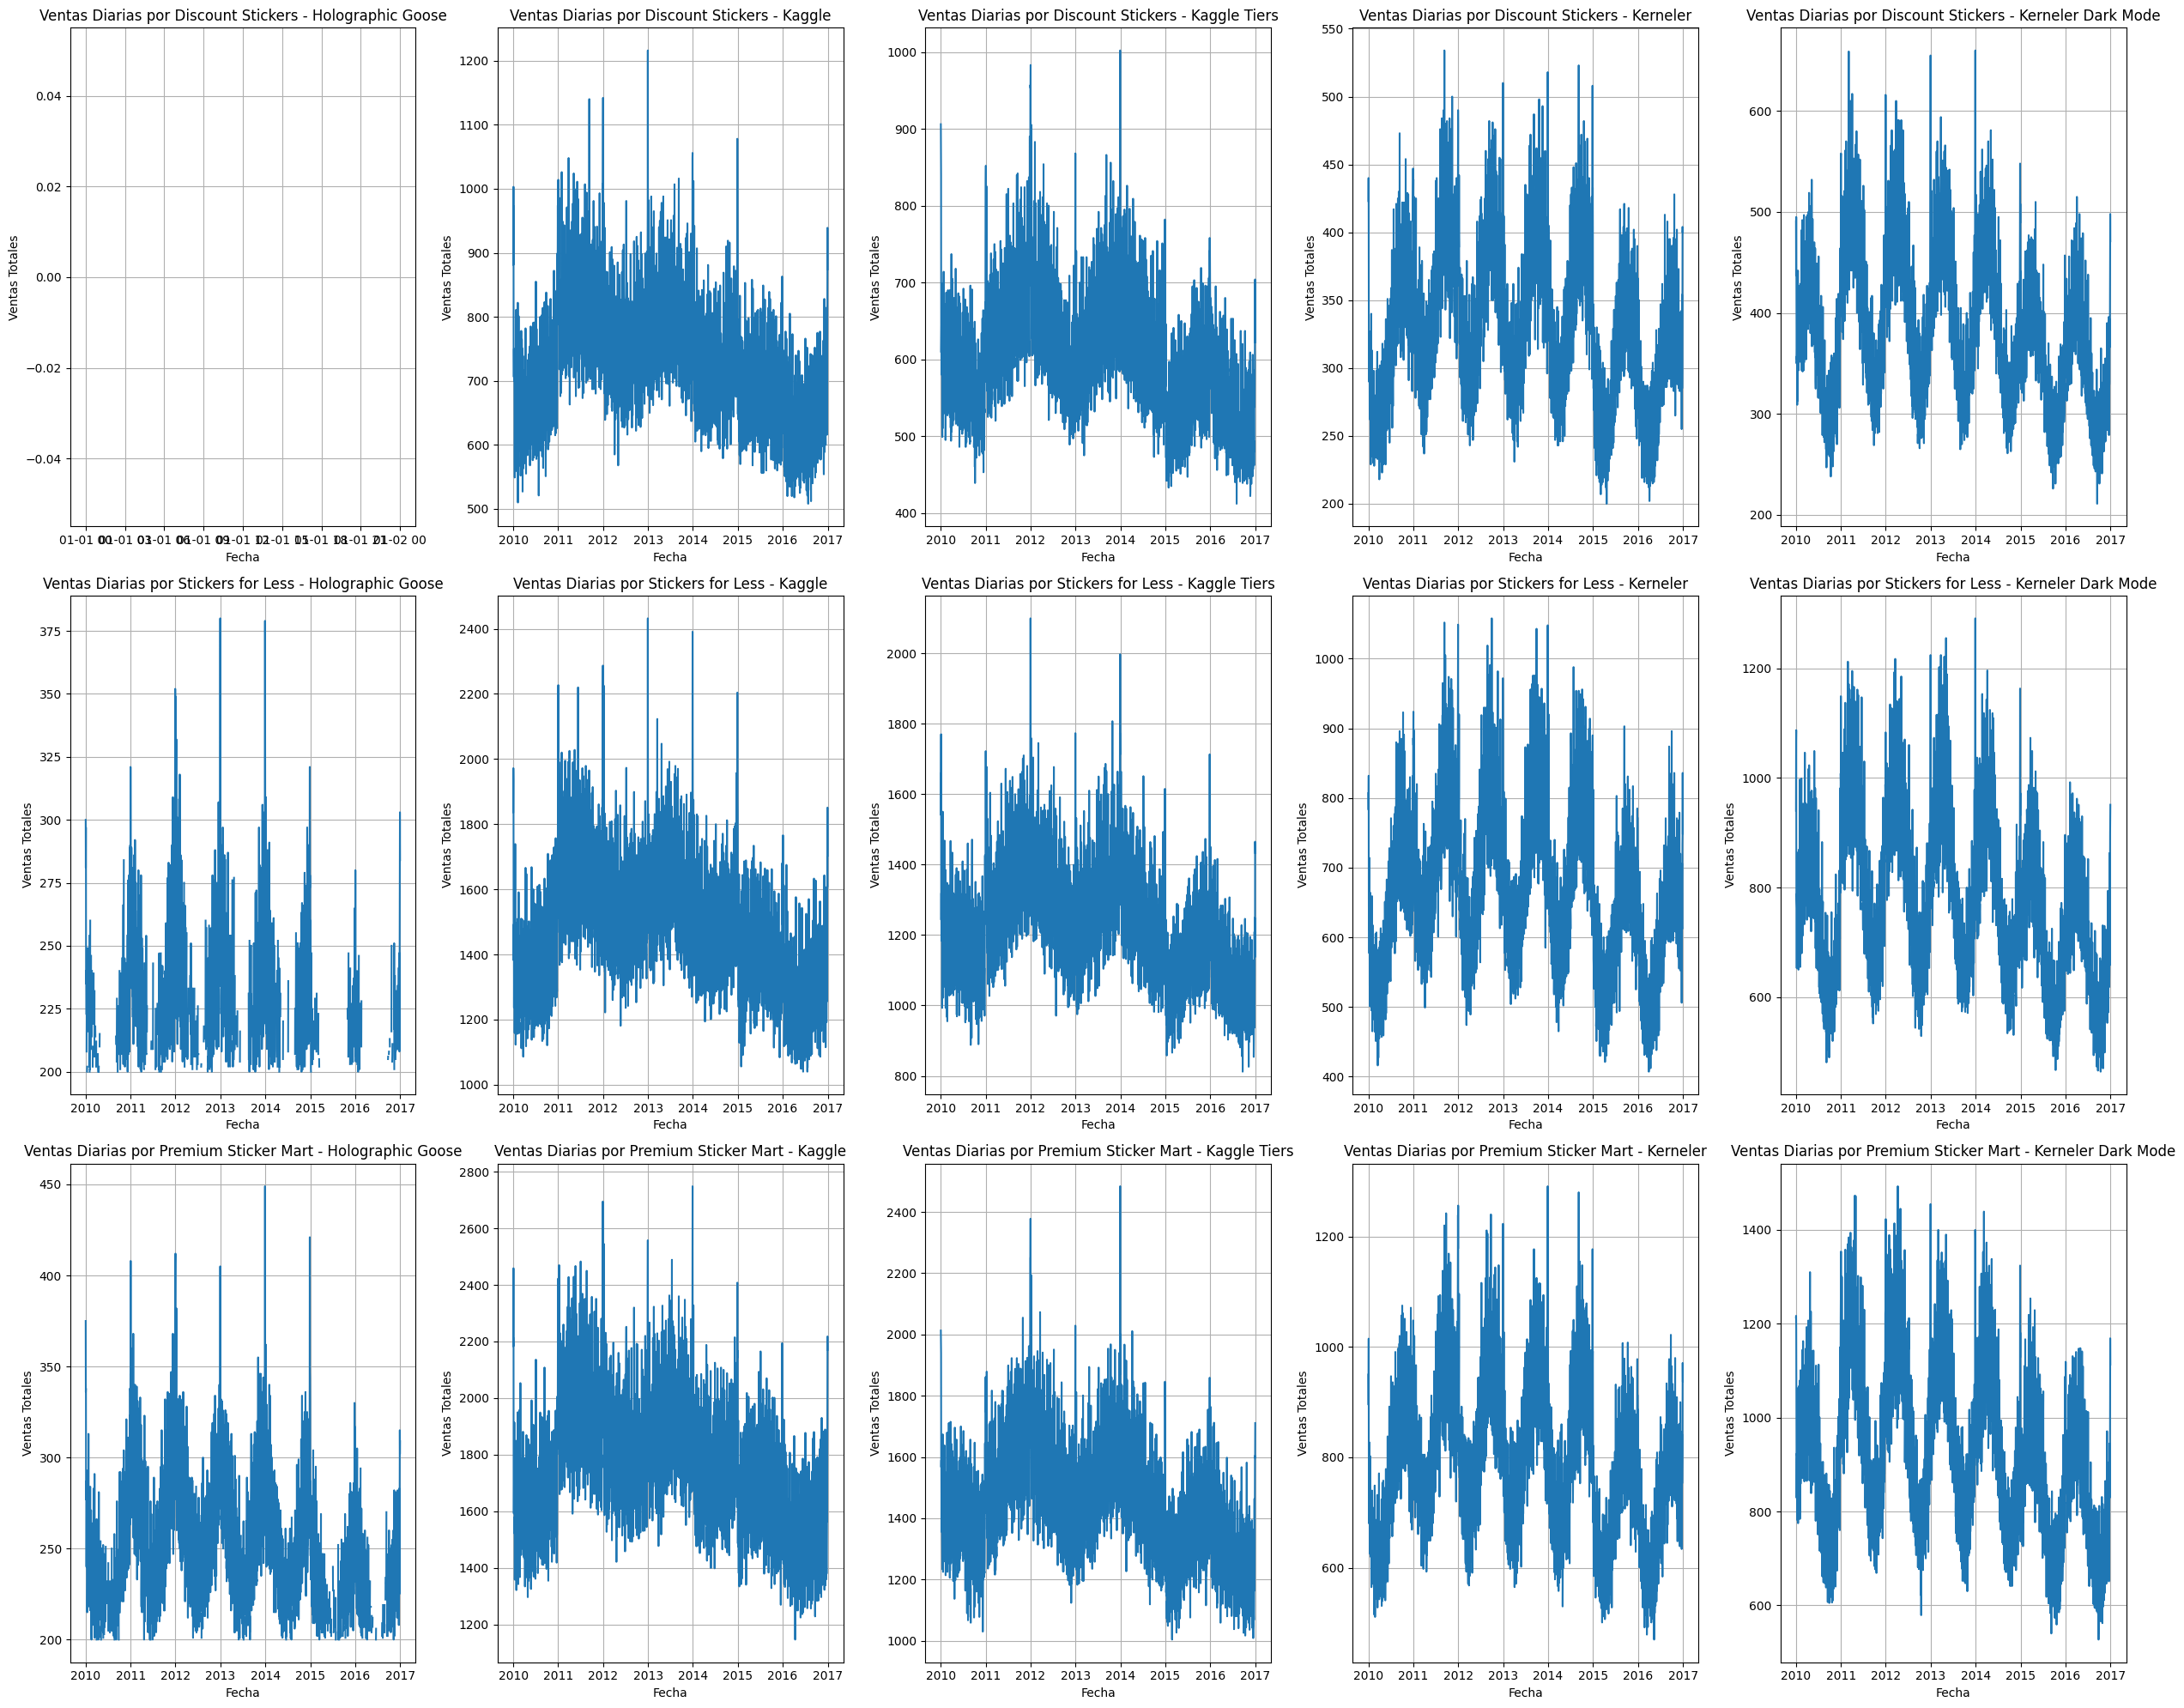

In [ ]:
#for de cada producto en cada tienda de Canada graficar plt.plot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
axes = axes.flatten()
for i, (product, store) in enumerate(train[train['country'] == 'Canada'][['product', 'store']].drop_duplicates().values): # Changed this line
    ax = axes[i]
    ax.plot(train[(train['country'] == 'Canada') & (train['store'] == store) & (train['product'] == product)]['date'],
            train[(train['country'] == 'Canada') & (train['store'] == store) & (train['product'] == product)]['num_sold'])
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas Totales')
    ax.set_title(f'Ventas Diarias por {store} - {product}')
    ax.grid(True)
plt.tight_layout()

#Finland

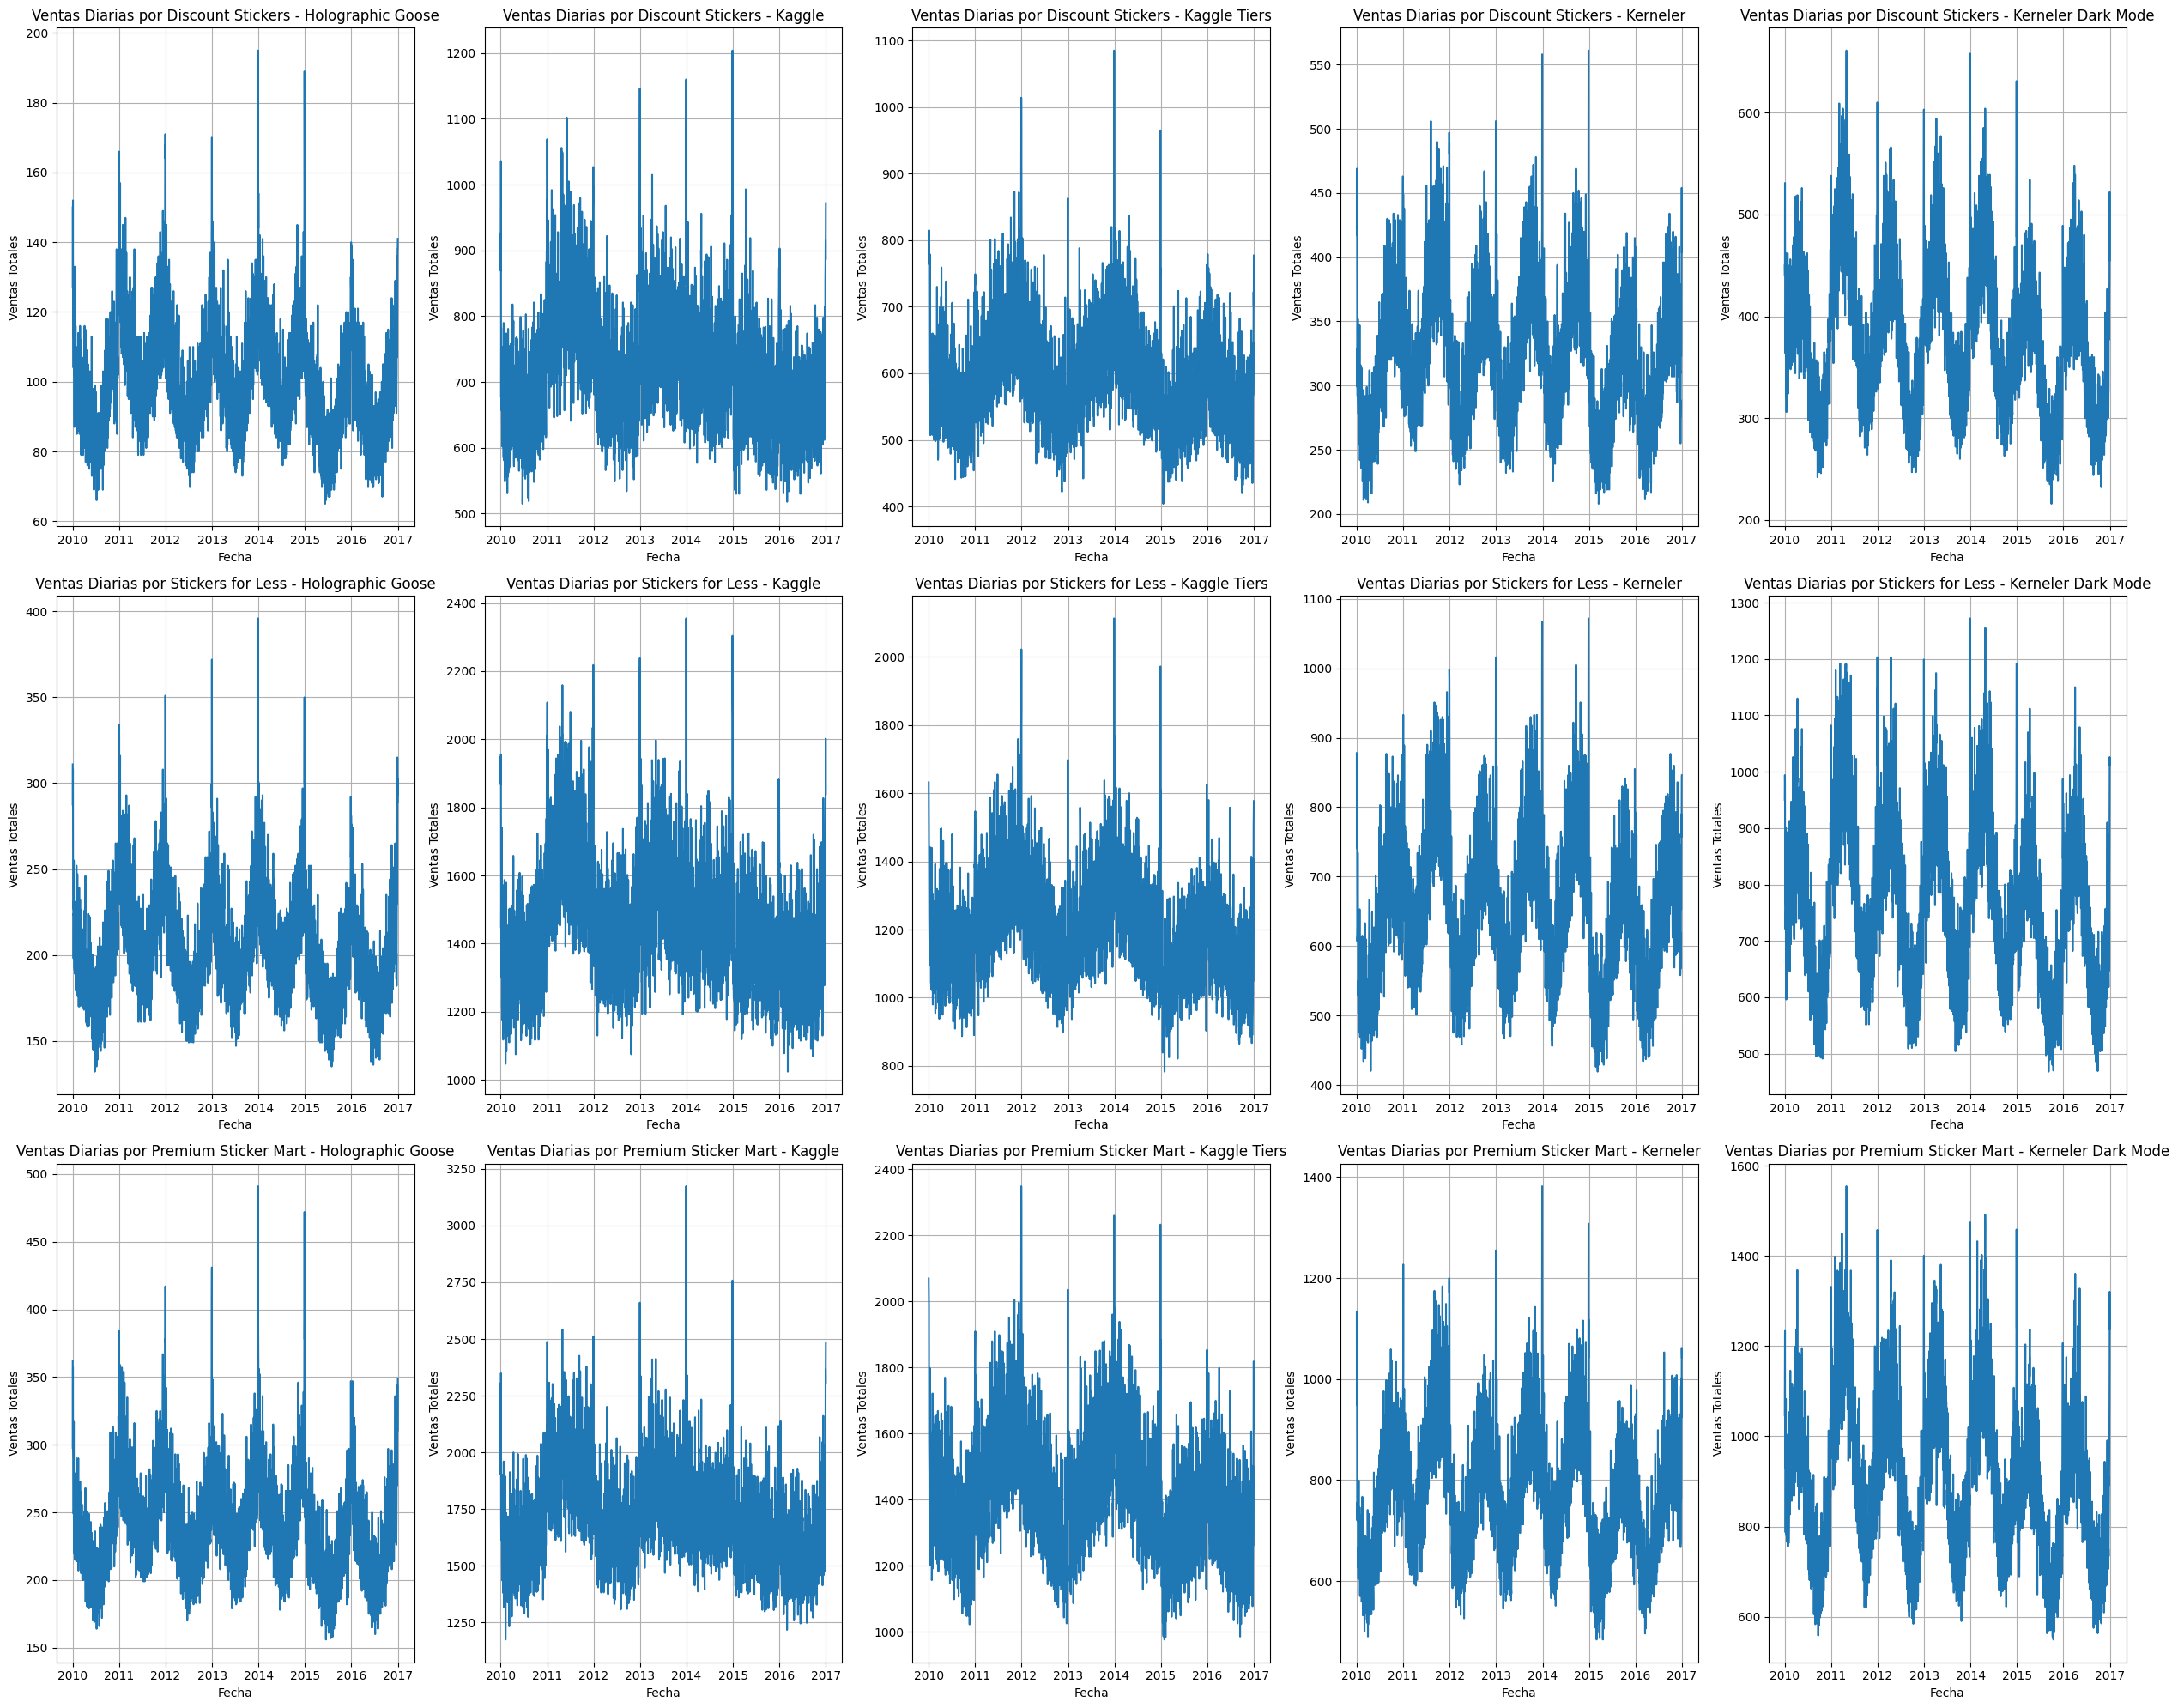

In [ ]:
#for de cada producto en cada tienda de Finland graficar plt.plot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
axes = axes.flatten()
for i, (product, store) in enumerate(train[train['country'] == 'Finland'][['product', 'store']].drop_duplicates().values): # Changed this line
    ax = axes[i]
    ax.plot(train[(train['country'] == 'Finland') & (train['store'] == store) & (train['product'] == product)]['date'],
            train[(train['country'] == 'Finland') & (train['store'] == store) & (train['product'] == product)]['num_sold'])
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas Totales')
    ax.set_title(f'Ventas Diarias por {store} - {product}')
    ax.grid(True)
plt.tight_layout()

#Italy

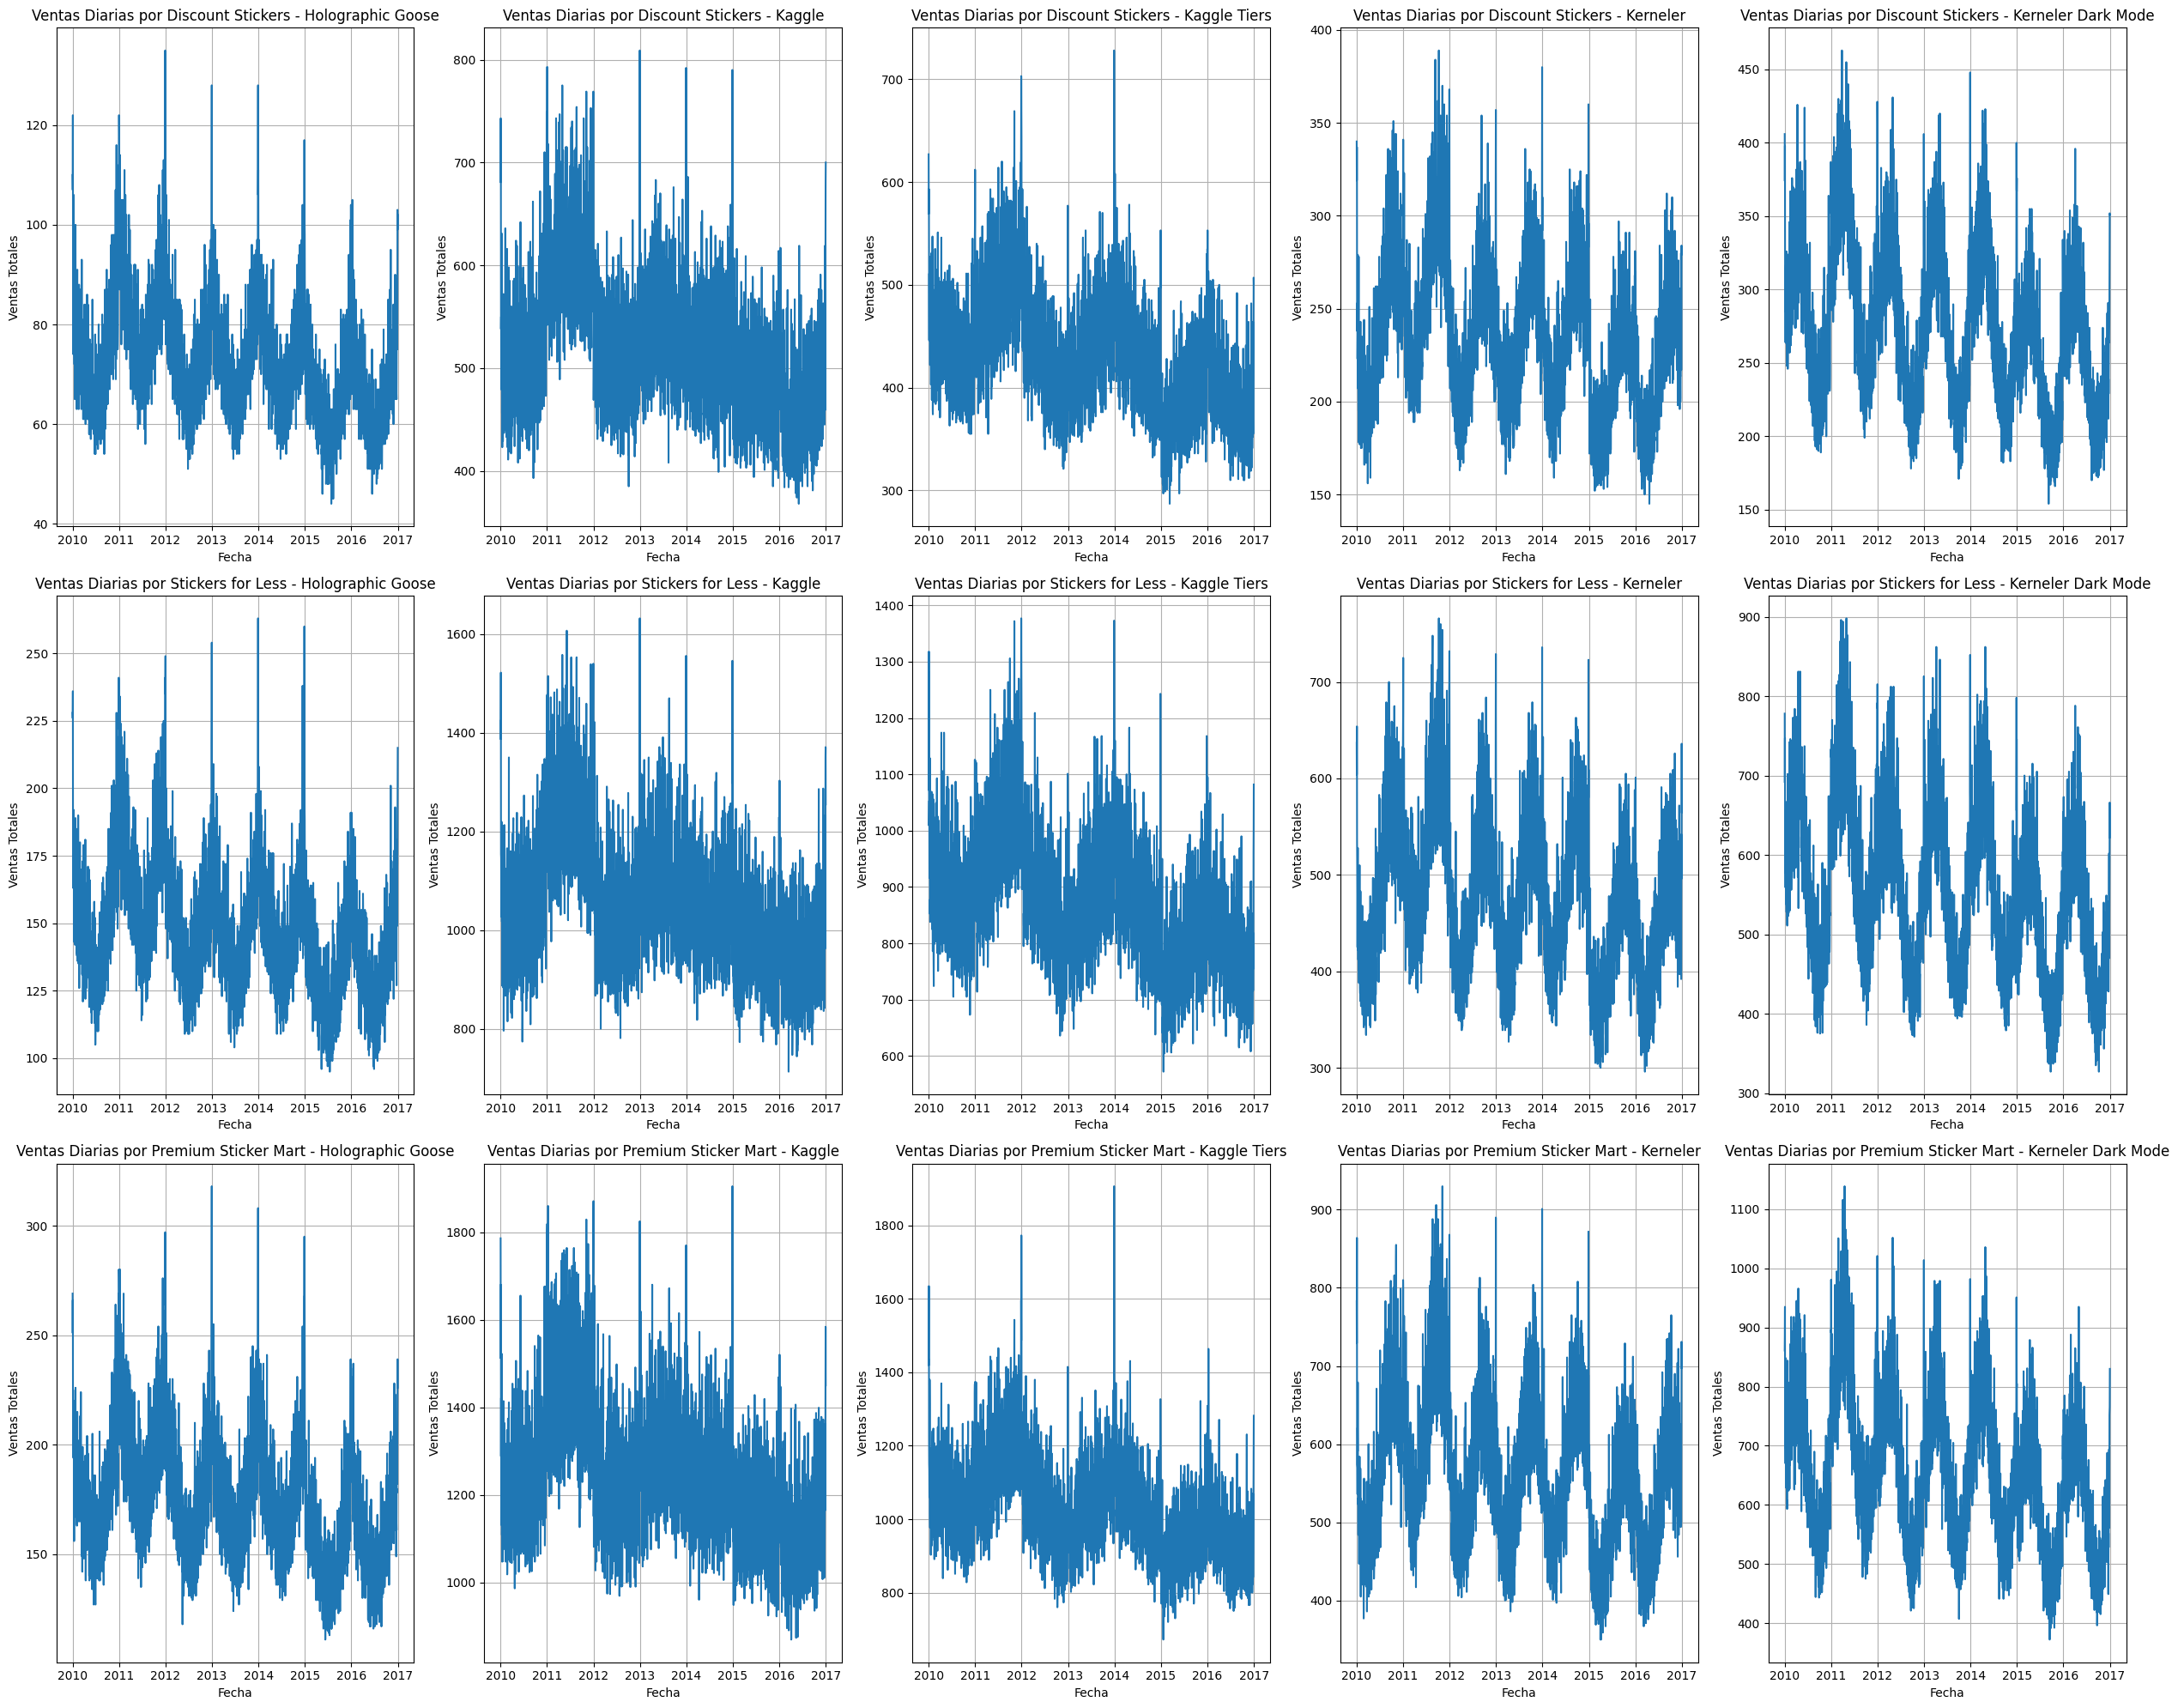

In [ ]:
#for de cada producto en cada tienda de Italy graficar plt.plot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
axes = axes.flatten()
for i, (product, store) in enumerate(train[train['country'] == 'Italy'][['product', 'store']].drop_duplicates().values): # Changed this line
    ax = axes[i]
    ax.plot(train[(train['country'] == 'Italy') & (train['store'] == store) & (train['product'] == product)]['date'],
            train[(train['country'] == 'Italy') & (train['store'] == store) & (train['product'] == product)]['num_sold'])
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas Totales')
    ax.set_title(f'Ventas Diarias por {store} - {product}')
    ax.grid(True)
plt.tight_layout()

#KENYA

#NO DATA FROM KENYA, DISCOUNT STICKERS, HOLOGRAPHIC GOOSE (2557)
#Kerneler (63)
#KERNELER DARK MODE (1)

#MISSING DATA FROM KENYA, STICKERS FOR LESS, HOLOGRAPHIC GOOSE (1358)

#MISSING DATA FROM KENYA, PREMIUM STICKER MART, HOLOGRAPHIC GOOSE (646)

In [ ]:
#iterar sobre tiendas y productos y saber la cantidad de NaN que hay por combinancion en Kenya
for store in train[train['country'] == 'Kenya']['store'].unique():
    for product in train[train['country'] == 'Kenya']['product'].unique():
        print(f"Tienda: {store}, Producto: {product}, NaN: {train[(train['country'] == 'Kenya') & (train['store'] == store) & (train['product'] == product)].isna().sum().sum()}")


Tienda: Discount Stickers, Producto: Holographic Goose, NaN: 2557
Tienda: Discount Stickers, Producto: Kaggle, NaN: 0
Tienda: Discount Stickers, Producto: Kaggle Tiers, NaN: 0
Tienda: Discount Stickers, Producto: Kerneler, NaN: 63
Tienda: Discount Stickers, Producto: Kerneler Dark Mode, NaN: 1
Tienda: Stickers for Less, Producto: Holographic Goose, NaN: 1358
Tienda: Stickers for Less, Producto: Kaggle, NaN: 0
Tienda: Stickers for Less, Producto: Kaggle Tiers, NaN: 0
Tienda: Stickers for Less, Producto: Kerneler, NaN: 0
Tienda: Stickers for Less, Producto: Kerneler Dark Mode, NaN: 0
Tienda: Premium Sticker Mart, Producto: Holographic Goose, NaN: 646
Tienda: Premium Sticker Mart, Producto: Kaggle, NaN: 0
Tienda: Premium Sticker Mart, Producto: Kaggle Tiers, NaN: 0
Tienda: Premium Sticker Mart, Producto: Kerneler, NaN: 0
Tienda: Premium Sticker Mart, Producto: Kerneler Dark Mode, NaN: 0


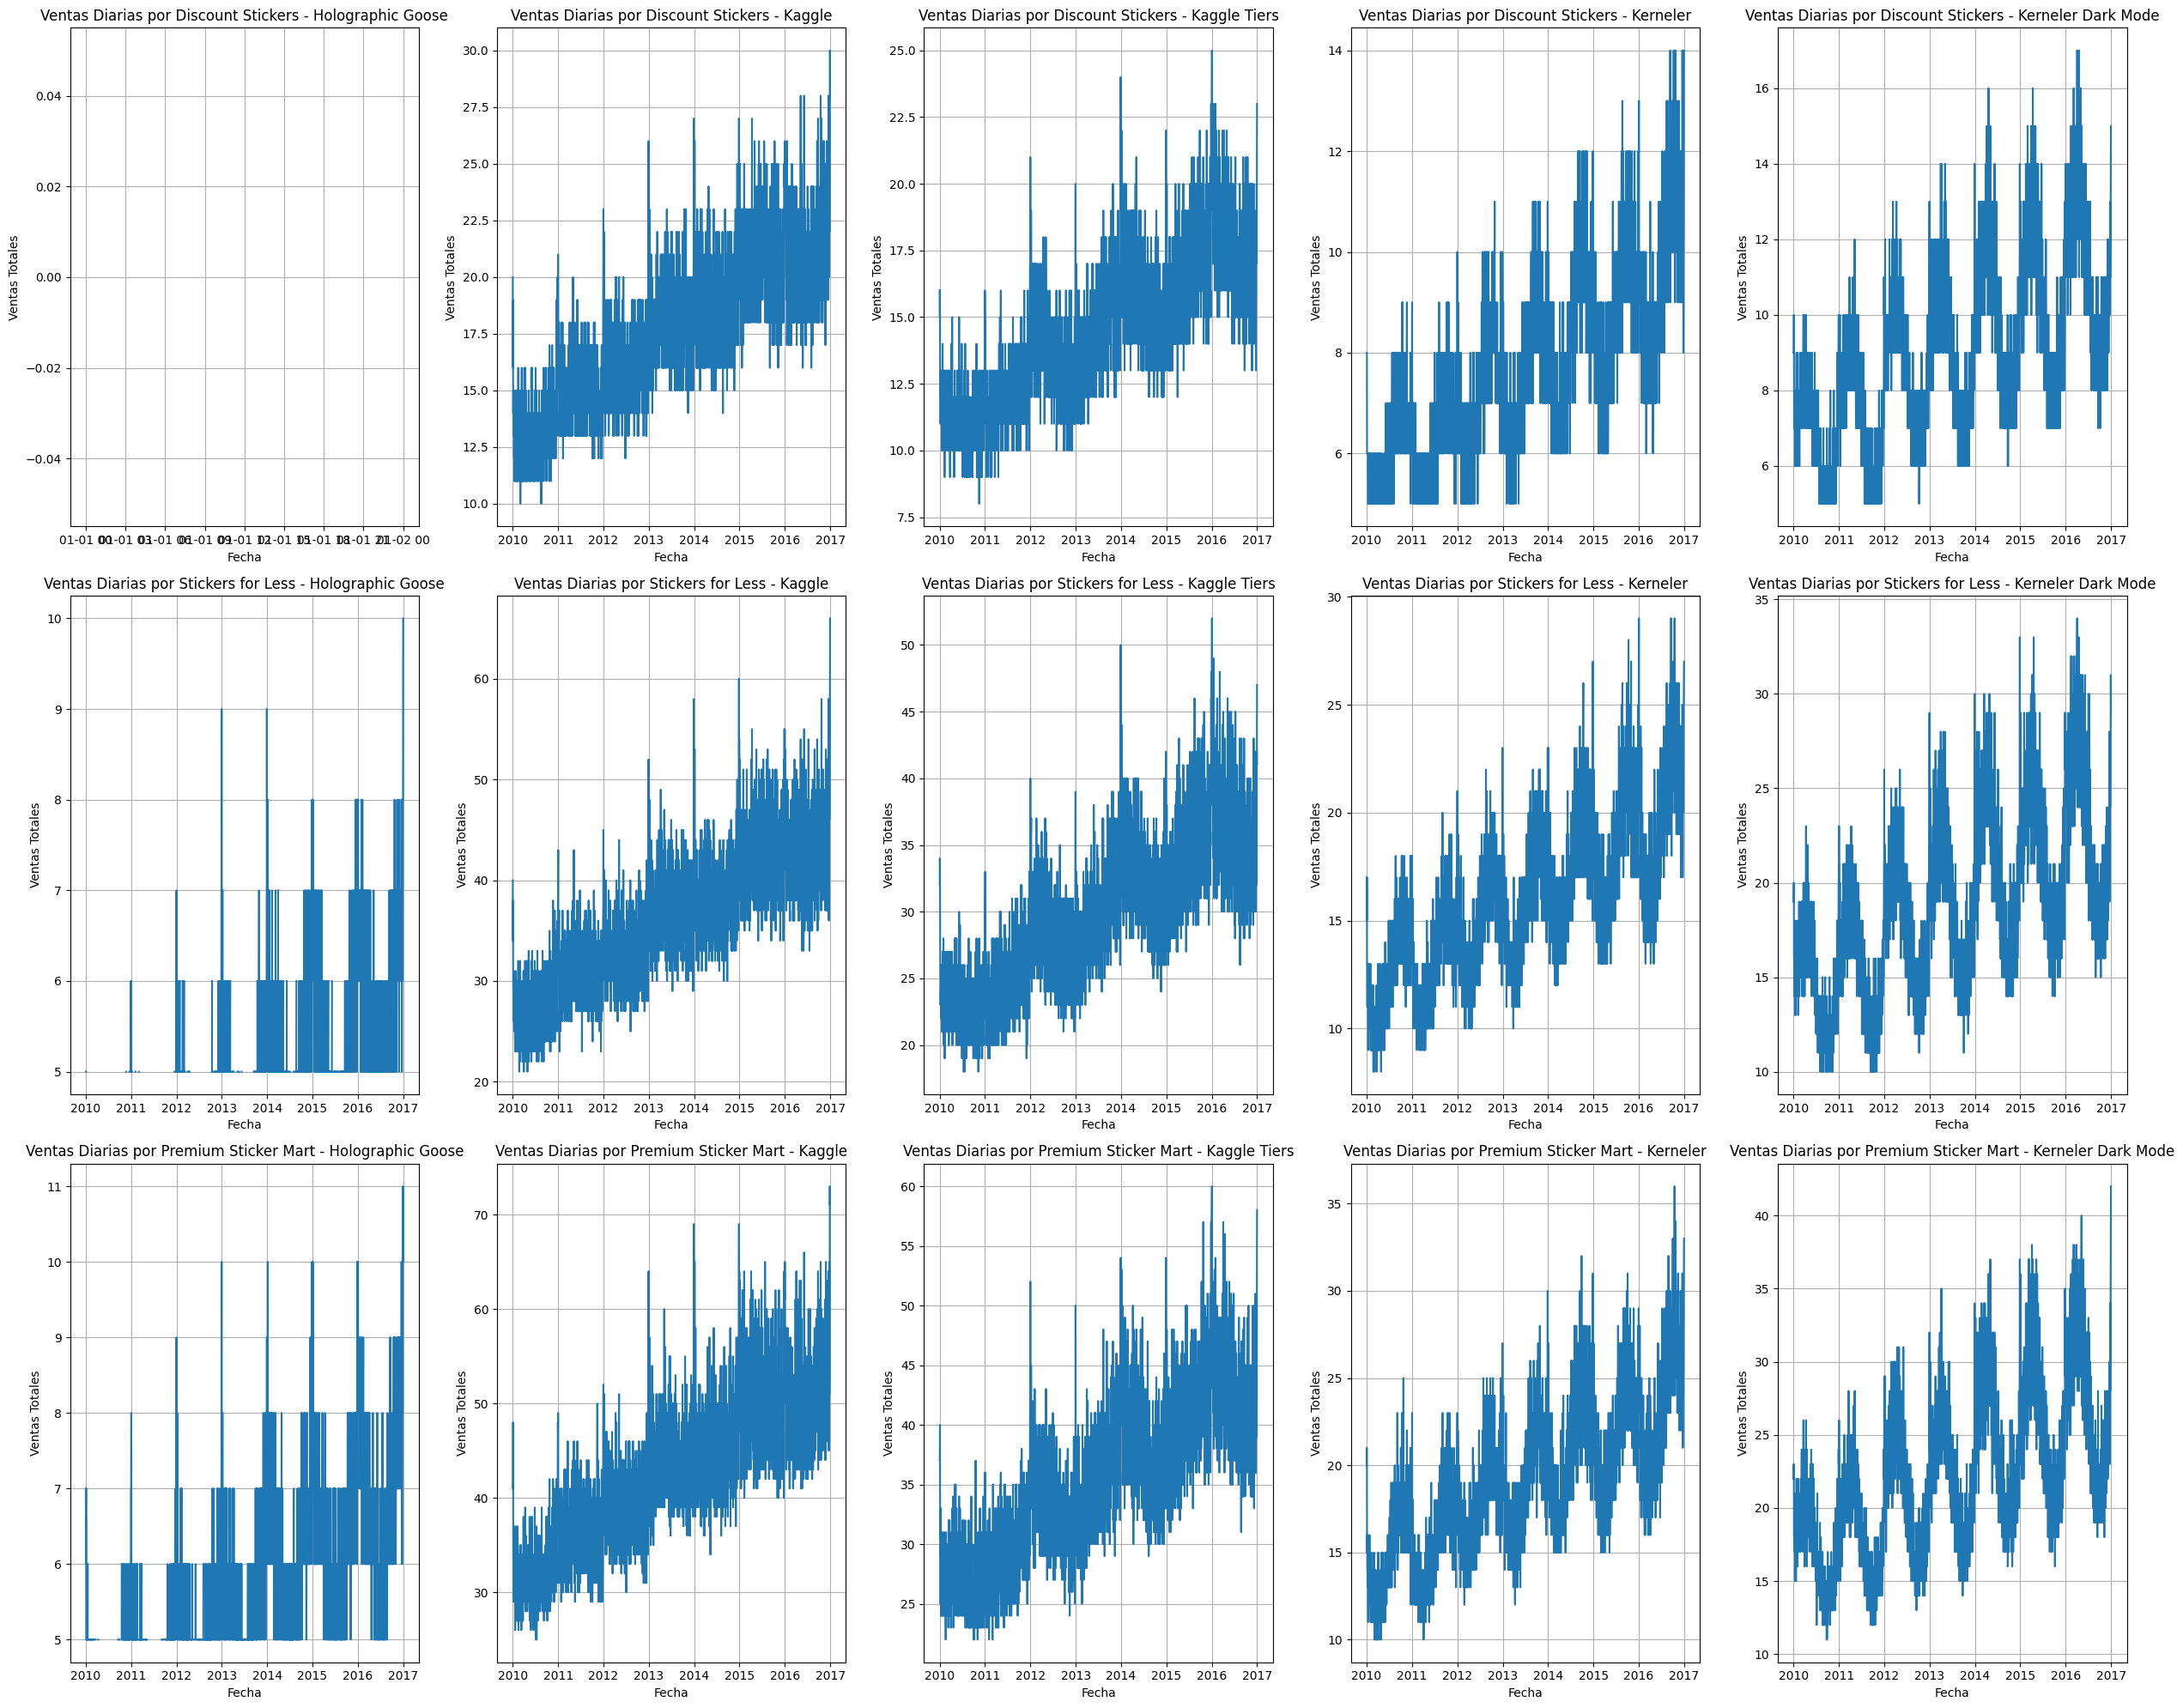

In [ ]:
#for de cada producto en cada tienda de Kenya graficar plt.plot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
axes = axes.flatten()
for i, (product, store) in enumerate(train[train['country'] == 'Kenya'][['product', 'store']].drop_duplicates().values): # Changed this line
    ax = axes[i]
    ax.plot(train[(train['country'] == 'Kenya') & (train['store'] == store) & (train['product'] == product)]['date'],
            train[(train['country'] == 'Kenya') & (train['store'] == store) & (train['product'] == product)]['num_sold'])
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas Totales')
    ax.set_title(f'Ventas Diarias por {store} - {product}')
    ax.grid(True)
plt.tight_layout()

#NORWAY

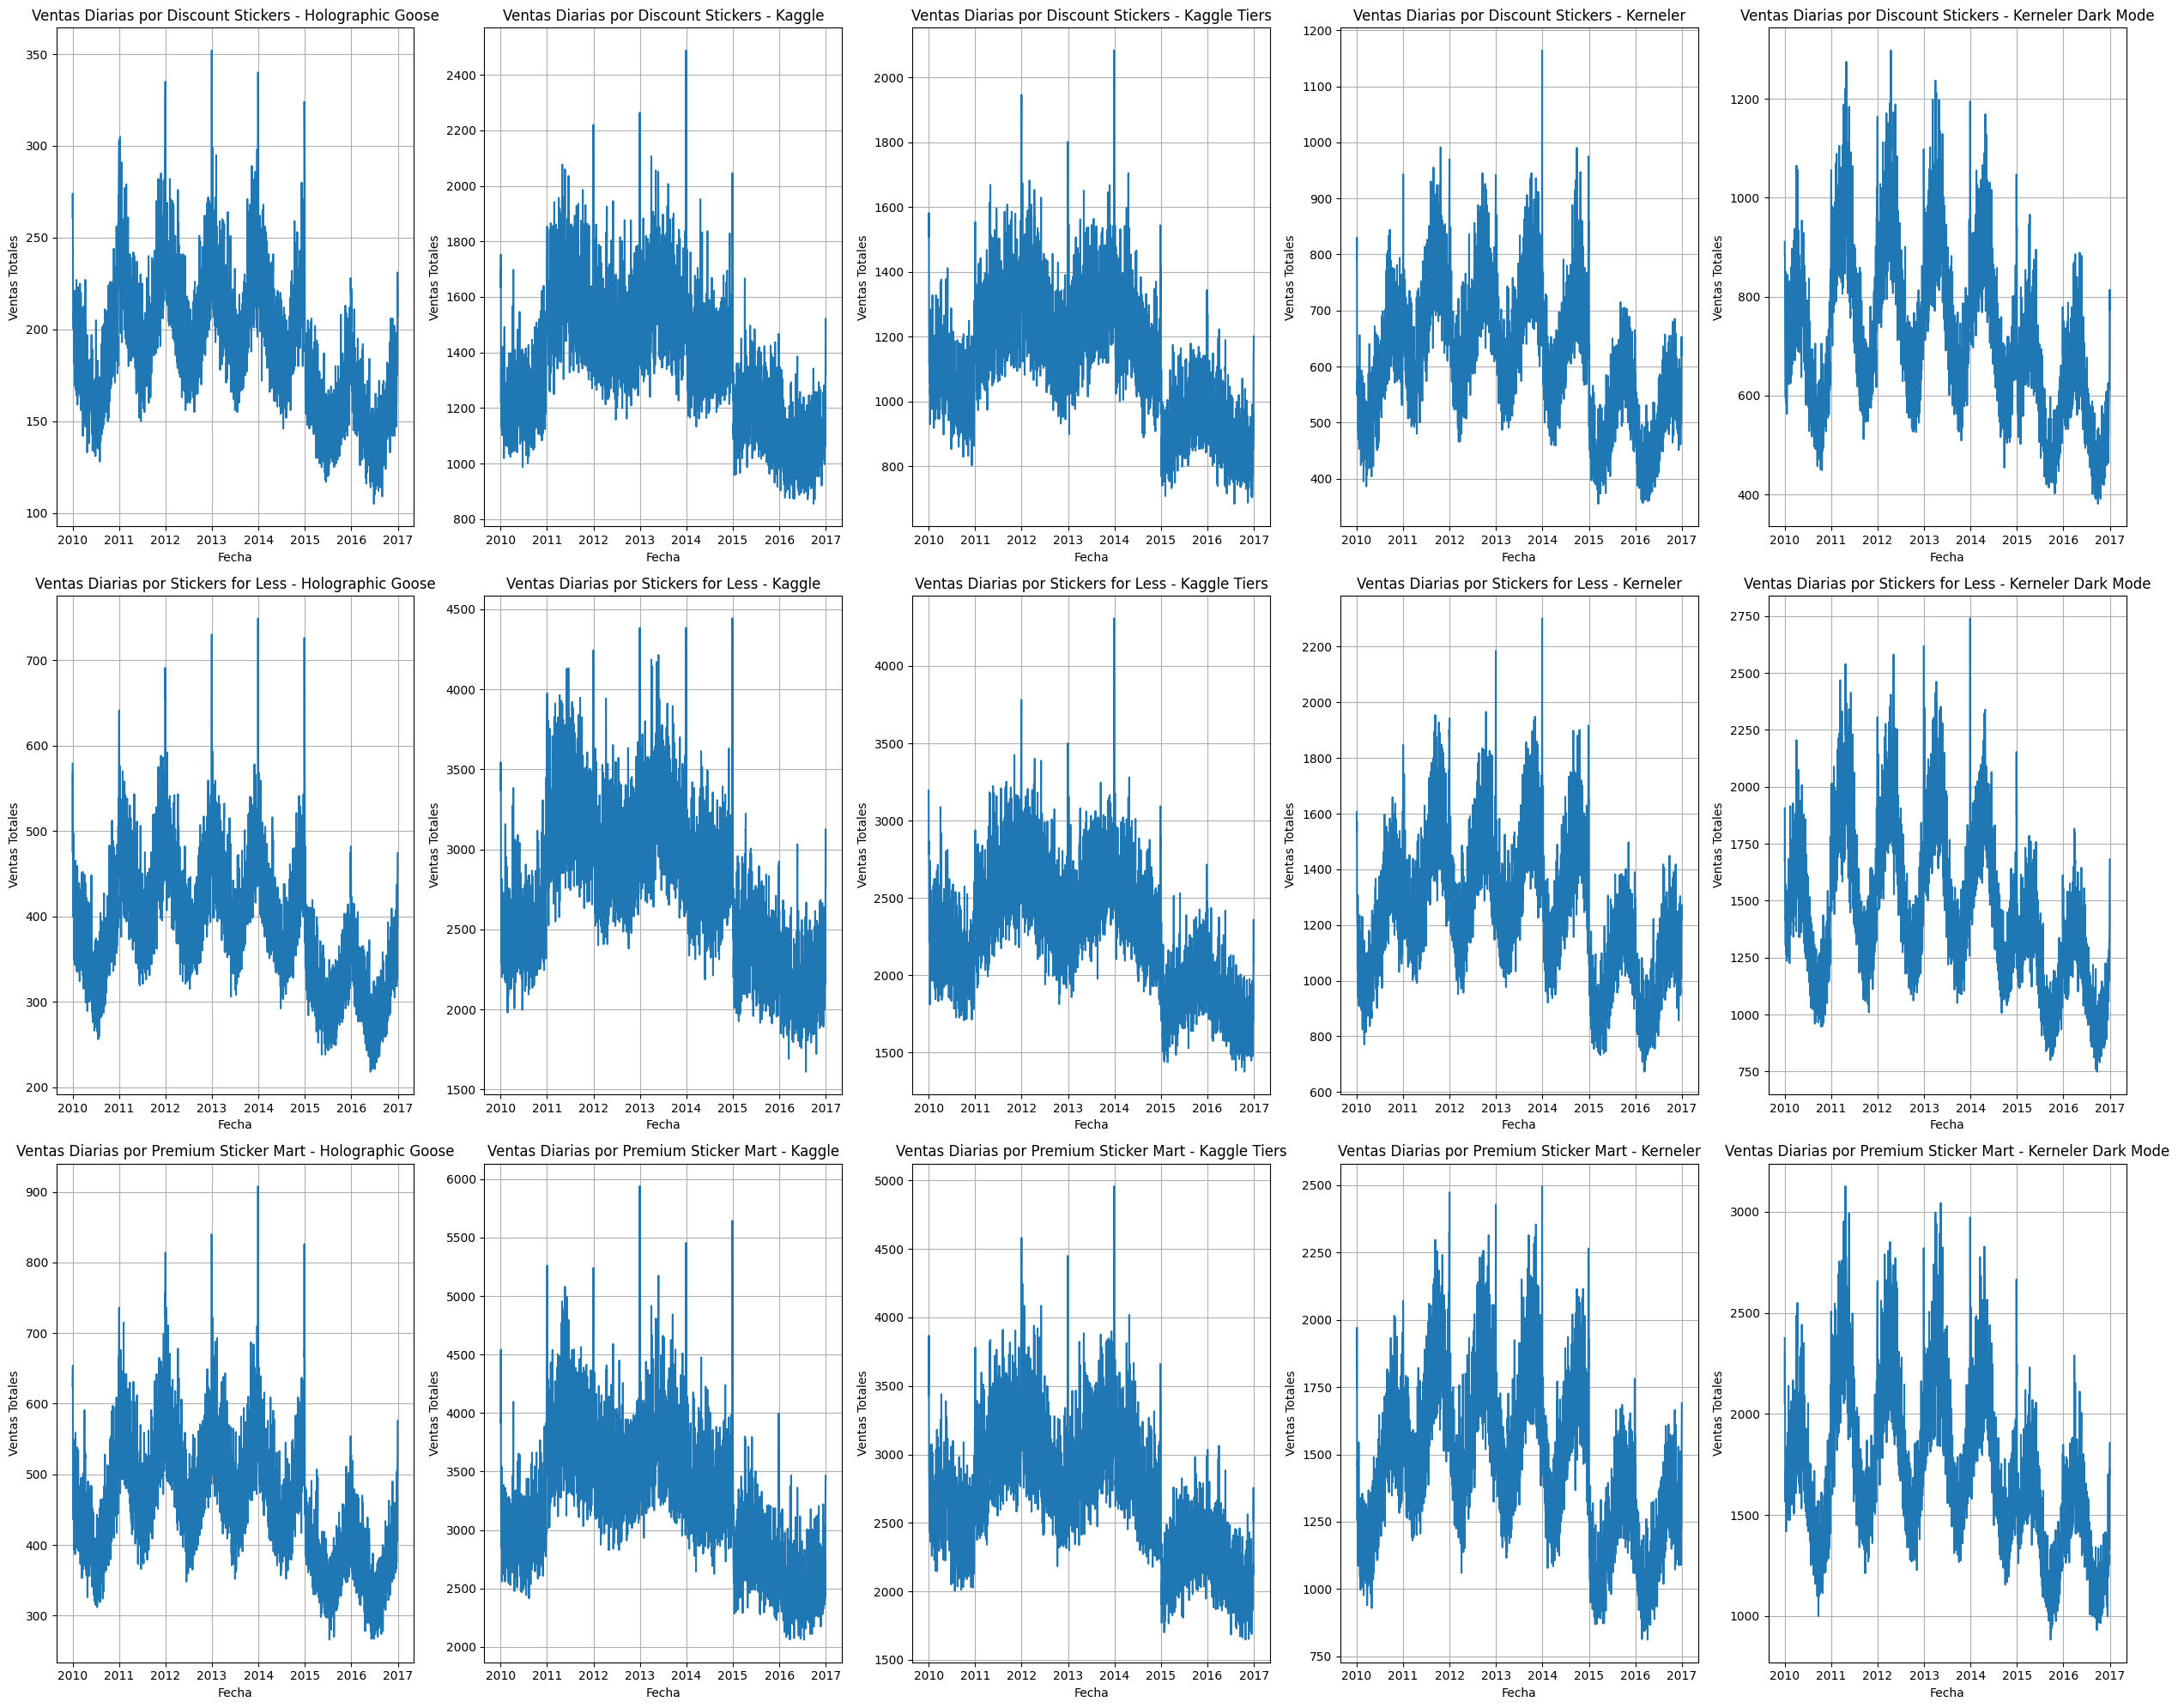

In [ ]:
#for de cada producto en cada tienda de Norway graficar plt.plot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
axes = axes.flatten()
for i, (product, store) in enumerate(train[train['country'] == 'Norway'][['product', 'store']].drop_duplicates().values): # Changed this line
    ax = axes[i]
    ax.plot(train[(train['country'] == 'Norway') & (train['store'] == store) & (train['product'] == product)]['date'],
            train[(train['country'] == 'Norway') & (train['store'] == store) & (train['product'] == product)]['num_sold'])
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas Totales')
    ax.set_title(f'Ventas Diarias por {store} - {product}')
    ax.grid(True)
plt.tight_layout()

#SINGAPORE

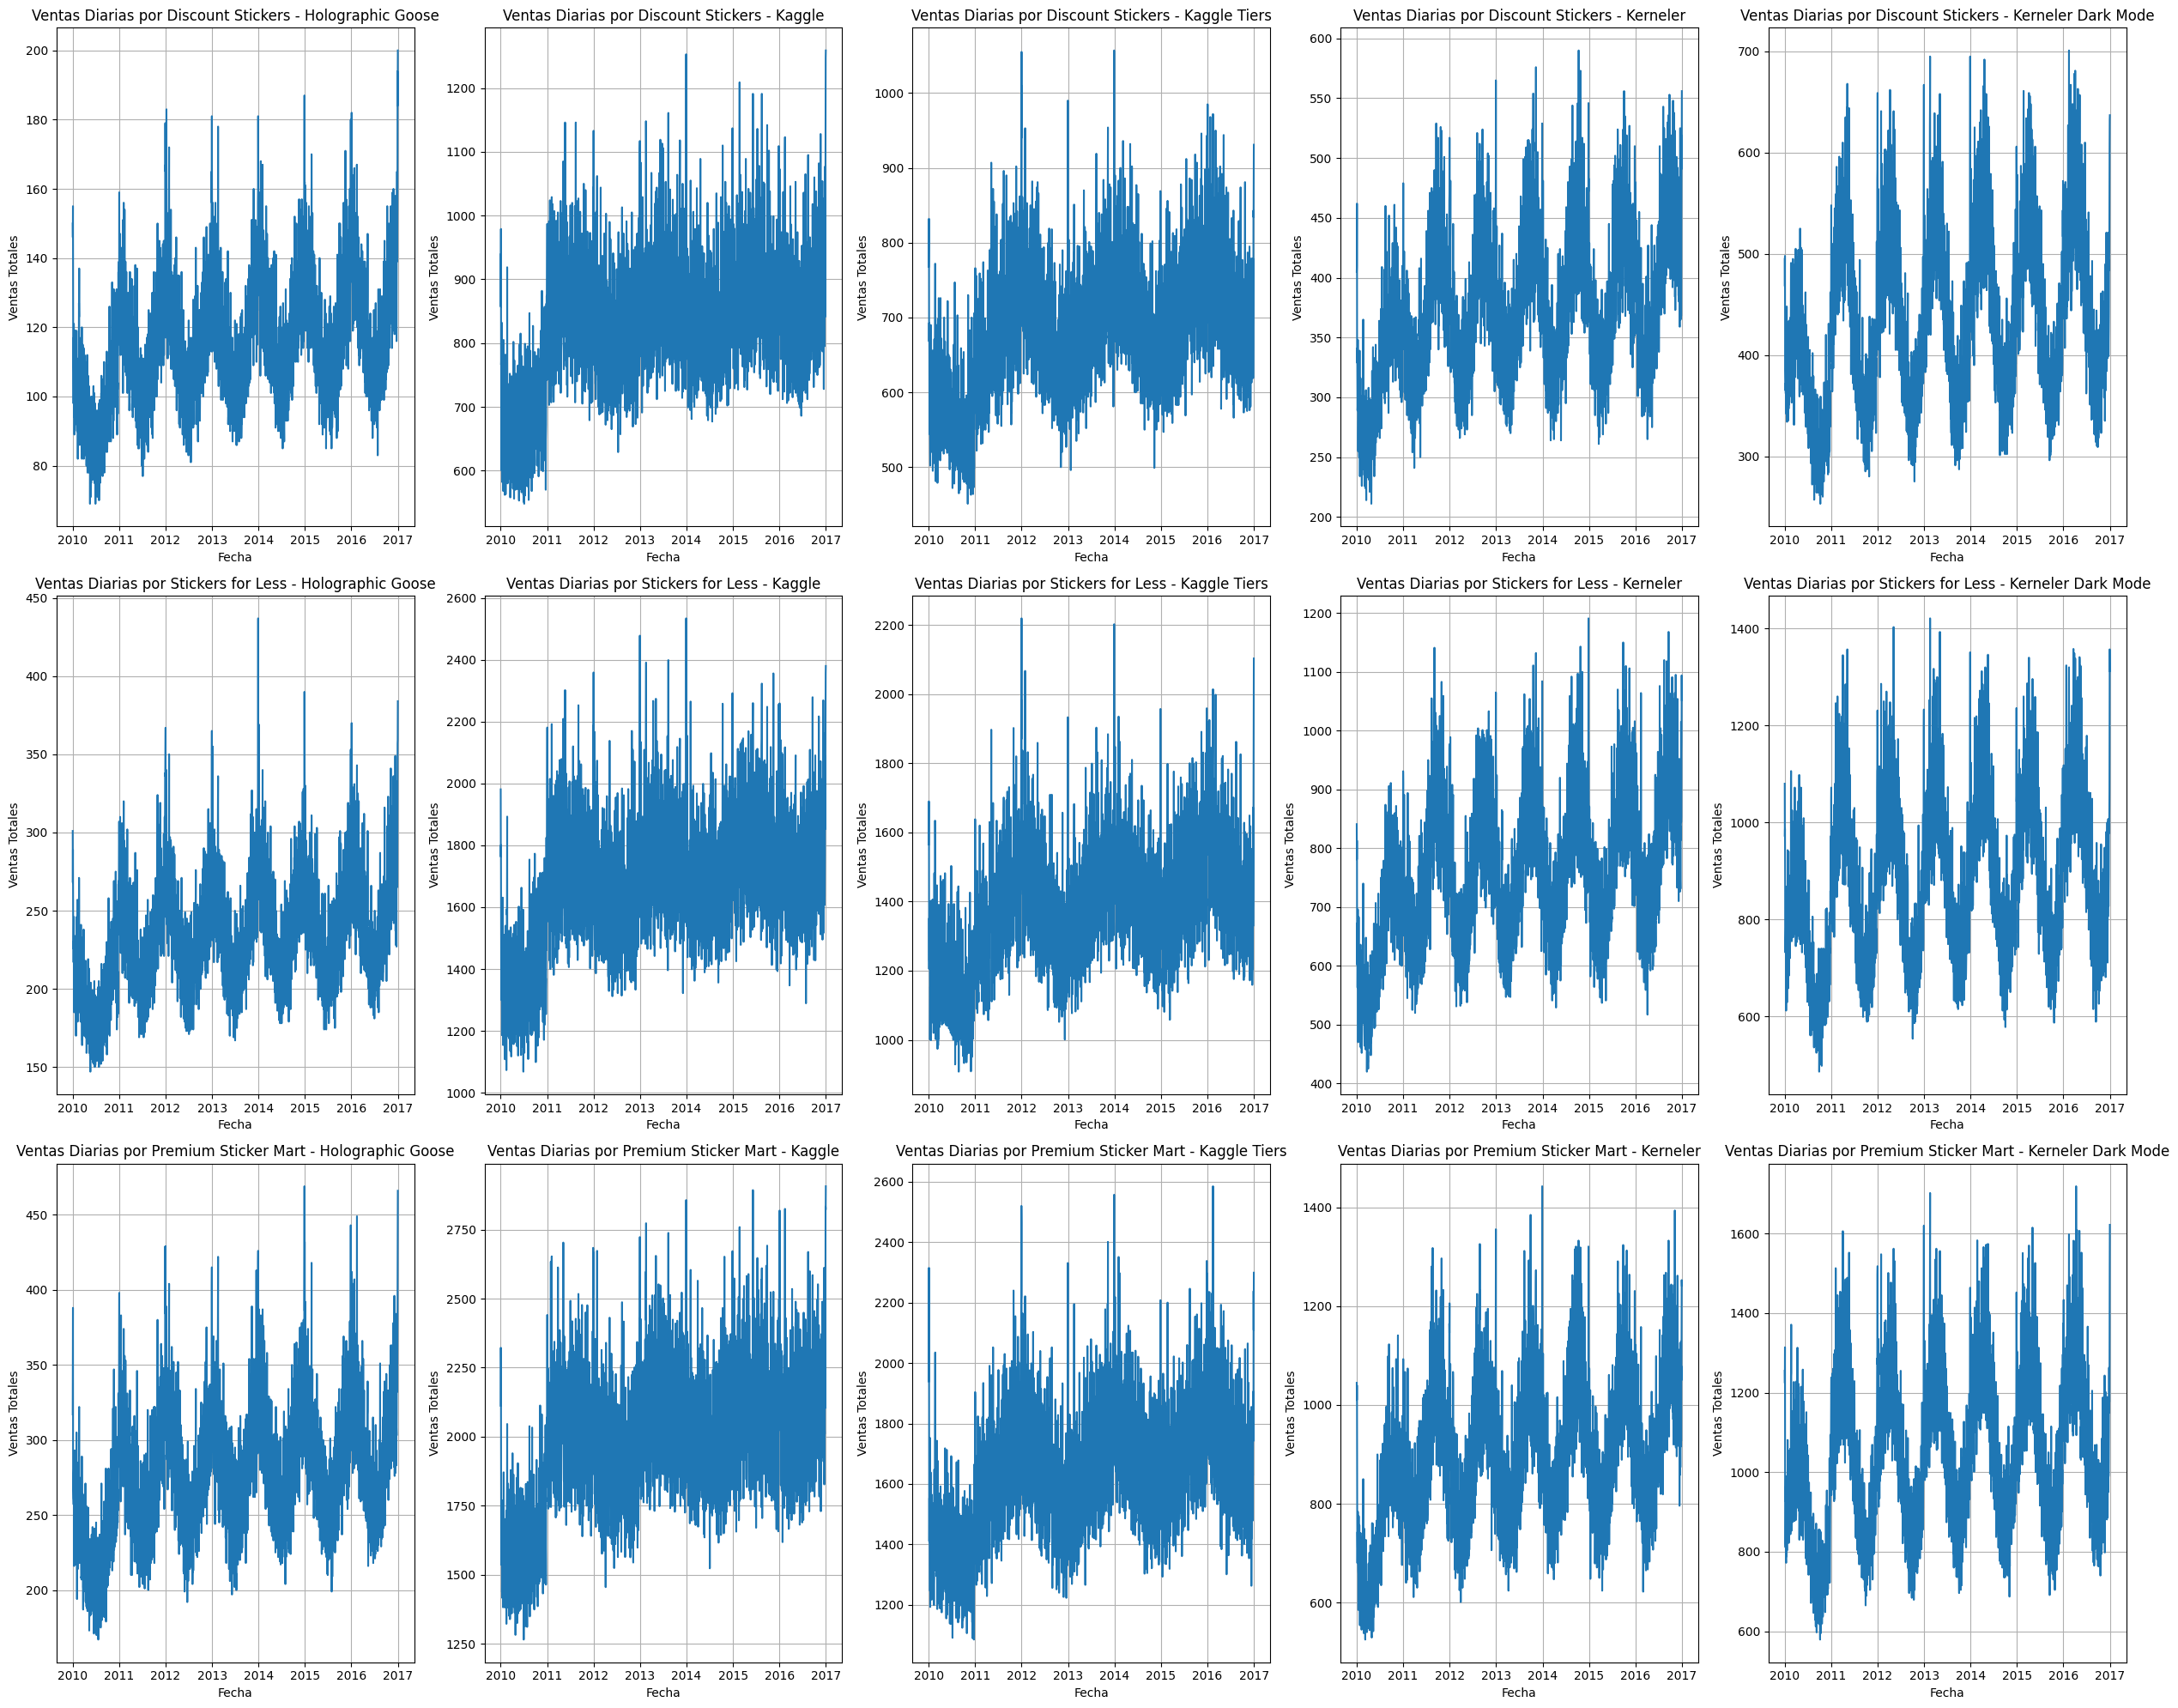

In [ ]:
#for de cada producto en cada tienda de Singapore graficar plt.plot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
axes = axes.flatten()
for i, (product, store) in enumerate(train[train['country'] == 'Singapore'][['product', 'store']].drop_duplicates().values): # Changed this line
    ax = axes[i]
    ax.plot(train[(train['country'] == 'Singapore') & (train['store'] == store) & (train['product'] == product)]['date'],
            train[(train['country'] == 'Singapore') & (train['store'] == store) & (train['product'] == product)]['num_sold'])
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas Totales')
    ax.set_title(f'Ventas Diarias por {store} - {product}')
    ax.grid(True)
plt.tight_layout()

creamos columnas para las vacaciones de cada pais

In [ ]:
import pandas as pd

def es_semana_de_ano_nuevo(fecha):
    """
    Determina si una fecha dada está dentro de la semana de Año Nuevo.

    Args:
        fecha: Una fecha en formato datetime.

    Returns:
        1 si la fecha está dentro de la semana de Año Nuevo, 0 en caso contrario.
    """

    return (fecha.month == 12 and fecha.day >= 28) or (fecha.month == 1 and fecha.day <= 2)

# Crear un DataFrame de ejemplo
data = {'fecha': pd.date_range('2022-12-25', periods=10)}
df = pd.DataFrame(data)

# Aplicar la función y convertir los valores booleanos a enteros
train['es_semana_de_ano_nuevo'] = train['date'].apply(es_semana_de_ano_nuevo).astype(int)

In [ ]:
test['es_semana_de_ano_nuevo'] = test['date'].apply(es_semana_de_ano_nuevo).astype(int)

In [ ]:
import holidays
# Crear un objeto de holidays para Canadá
ca_holidays = holidays.CA()
fi_holidays = holidays.FI()
it_holidays = holidays.IT()
ke_holidays = holidays.KE()
no_holidays = holidays.NO()
sg_holidays = holidays.SG()

# Crear una nueva columna para indicar si es festivo en train
train['is_ca_holiday'] = train.apply(lambda row: 1 if row['date'] in ca_holidays and row['country'] == 'Canada' else 0, axis=1)
train['is_fi_holiday'] = train.apply(lambda row: 1 if row['date'] in fi_holidays and row['country'] == 'Finland' else 0, axis=1)
train['is_it_holiday'] = train.apply(lambda row: 1 if row['date'] in it_holidays and row['country'] == 'Italy' else 0, axis=1)
train['is_ke_holiday'] = train.apply(lambda row: 1 if row['date'] in ke_holidays and row['country'] == 'Kenya' else 0, axis=1)
train['is_no_holiday'] = train.apply(lambda row: 1 if row['date'] in no_holidays and row['country'] == 'Norway' else 0, axis=1)
train['is_sg_holiday'] = train.apply(lambda row: 1 if row['date'] in sg_holidays and row['country'] == 'Singapore' else 0, axis=1)
# Crear una nueva columna para indicar si es festivo en test
test['is_ca_holiday'] = test.apply(lambda row: 1 if row['date'] in ca_holidays and row['country'] == 'Canada' else 0, axis=1)
test['is_fi_holiday'] = test.apply(lambda row: 1 if row['date'] in fi_holidays and row['country'] == 'Finland' else 0, axis=1)
test['is_it_holiday'] = test.apply(lambda row: 1 if row['date'] in it_holidays and row['country'] == 'Italy' else 0, axis=1)
test['is_ke_holiday'] = test.apply(lambda row: 1 if row['date'] in ke_holidays and row['country'] == 'Kenya' else 0, axis=1)
test['is_no_holiday'] = test.apply(lambda row: 1 if row['date'] in no_holidays and row['country'] == 'Norway' else 0, axis=1)
test['is_sg_holiday'] = test.apply(lambda row: 1 if row['date'] in sg_holidays and row['country'] == 'Singapore' else 0, axis=1)

In [ ]:
def prepare_features(df):
    df['dia_semana'] = df['date'].dt.dayofweek
    df['mes'] = df['date'].dt.month
    df['es_finde'] = df['date'].dt.dayofweek >= 5
    df['es_finde'] = df['es_finde'].astype(int)
    df['trimestre'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df.drop('date', axis=1, inplace=True)
    return df


In [ ]:
train_prepared = prepare_features(train)
train_prepared.head()

id country              store             product  num_sold  \
0   0  Canada  Discount Stickers   Holographic Goose       NaN   
1   1  Canada  Discount Stickers              Kaggle     973.0   
2   2  Canada  Discount Stickers        Kaggle Tiers     906.0   
3   3  Canada  Discount Stickers            Kerneler     423.0   
4   4  Canada  Discount Stickers  Kerneler Dark Mode     491.0   

   PIB_per_capita  es_semana_de_ano_nuevo  is_ca_holiday  is_fi_holiday  \
0    47560.666601                       1              1              0   
1    47560.666601                       1              1              0   
2    47560.666601                       1              1              0   
3    47560.666601                       1              1              0   
4    47560.666601                       1              1              0   

   is_it_holiday  is_ke_holiday  is_no_holiday  is_sg_holiday  dia_semana  \
0              0              0              0              0           4   
1              0              0              0              0           4   
2              0              0              0              0           4   
3              0              0              0              0           4   
4              0              0              0              0           4   

   mes  es_finde  trimestre  year  
0    1         0          1  2010  
1    1         0          1  2010  
2    1         0          1  2010  
3    1         0          1  2010  
4    1         0          1  2010

In [ ]:
test_prepared = prepare_features(test)
test_prepared.head()

id country              store             product  PIB_per_capita  \
0  230130  Canada  Discount Stickers   Holographic Goose    45129.628117   
1  230131  Canada  Discount Stickers              Kaggle    45129.628117   
2  230132  Canada  Discount Stickers        Kaggle Tiers    45129.628117   
3  230133  Canada  Discount Stickers            Kerneler    45129.628117   
4  230134  Canada  Discount Stickers  Kerneler Dark Mode    45129.628117   

   es_semana_de_ano_nuevo  is_ca_holiday  is_fi_holiday  is_it_holiday  \
0                       1              1              0              0   
1                       1              1              0              0   
2                       1              1              0              0   
3                       1              1              0              0   
4                       1              1              0              0   

   is_ke_holiday  is_no_holiday  is_sg_holiday  dia_semana  mes  es_finde  \
0              0              0              0           6    1         1   
1              0              0              0           6    1         1   
2              0              0              0           6    1         1   
3              0              0              0           6    1         1   
4              0              0              0           6    1         1   

   trimestre  year  
0          1  2017  
1          1  2017  
2          1  2017  
3          1  2017  
4          1  2017

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#one-hot encoding for categorical features
encoder = OneHotEncoder()
categorical_features = ['country', 'store', 'product']
encoded_features = encoder.fit_transform(train_prepared[categorical_features])
# Convert sparse matrix to dense array
encoded_features_dense = encoded_features.toarray()
encoded_df = pd.DataFrame(encoded_features_dense, columns=encoder.get_feature_names_out(categorical_features))
train_prepared = pd.concat([train_prepared, encoded_df], axis=1)
train_prepared.drop(categorical_features, axis=1, inplace=True)

In [ ]:
encoded_features = encoder.transform(test_prepared[categorical_features])
# Convert sparse matrix to dense array
encoded_features_dense = encoded_features.toarray()
encoded_df = pd.DataFrame(encoded_features_dense, columns=encoder.get_feature_names_out(categorical_features))
test_prepared = pd.concat([test_prepared, encoded_df], axis=1)
test_prepared.drop(categorical_features, axis=1, inplace=True)

In [ ]:
#drop id
train_prepared.drop('id', axis=1, inplace=True)

In [ ]:
train_prepared.head()

num_sold  PIB_per_capita  es_semana_de_ano_nuevo  is_ca_holiday  \
0       NaN    47560.666601                       1              1   
1     973.0    47560.666601                       1              1   
2     906.0    47560.666601                       1              1   
3     423.0    47560.666601                       1              1   
4     491.0    47560.666601                       1              1   

   is_fi_holiday  is_it_holiday  is_ke_holiday  is_no_holiday  is_sg_holiday  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   dia_semana  ...  country_Norway  country_Singapore  \
0           4  ...             0.0                0.0   
1           4  ...             0.0                0.0   
2           4  ...             0.0                0.0   
3           4  ...             0.0                0.0   
4           4  ...             0.0                0.0   

   store_Discount Stickers  store_Premium Sticker Mart  \
0                      1.0                         0.0   
1                      1.0                         0.0   
2                      1.0                         0.0   
3                      1.0                         0.0   
4                      1.0                         0.0   

   store_Stickers for Less  product_Holographic Goose  product_Kaggle  \
0                      0.0                        1.0             0.0   
1                      0.0                        0.0             1.0   
2                      0.0                        0.0             0.0   
3                      0.0                        0.0             0.0   
4                      0.0                        0.0             0.0   

   product_Kaggle Tiers  product_Kerneler  product_Kerneler Dark Mode  
0                   0.0               0.0                         0.0  
1                   0.0               0.0                         0.0  
2                   1.0               0.0                         0.0  
3                   0.0               1.0                         0.0  
4                   0.0               0.0                         1.0  

[5 rows x 28 columns]

In [ ]:
test_prepared.head()

id  PIB_per_capita  es_semana_de_ano_nuevo  is_ca_holiday  \
0  230130       10.717294                       1              1   
1  230131       10.717294                       1              1   
2  230132       10.717294                       1              1   
3  230133       10.717294                       1              1   
4  230134       10.717294                       1              1   

   is_fi_holiday  is_it_holiday  is_ke_holiday  is_no_holiday  is_sg_holiday  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   dia_semana  ...  country_Norway  country_Singapore  \
0           6  ...             0.0                0.0   
1           6  ...             0.0                0.0   
2           6  ...             0.0                0.0   
3           6  ...             0.0                0.0   
4           6  ...             0.0                0.0   

   store_Discount Stickers  store_Premium Sticker Mart  \
0                      1.0                         0.0   
1                      1.0                         0.0   
2                      1.0                         0.0   
3                      1.0                         0.0   
4                      1.0                         0.0   

   store_Stickers for Less  product_Holographic Goose  product_Kaggle  \
0                      0.0                        1.0             0.0   
1                      0.0                        0.0             1.0   
2                      0.0                        0.0             0.0   
3                      0.0                        0.0             0.0   
4                      0.0                        0.0             0.0   

   product_Kaggle Tiers  product_Kerneler  product_Kerneler Dark Mode  
0                   0.0               0.0                         0.0  
1                   0.0               0.0                         0.0  
2                   1.0               0.0                         0.0  
3                   0.0               1.0                         0.0  
4                   0.0               0.0                         1.0  

[5 rows x 28 columns]

In [ ]:
#convertir en log(PIB_per_capita)
train_prepared['PIB_per_capita'] = np.log(train_prepared['PIB_per_capita'])
test_prepared['PIB_per_capita'] = np.log(test_prepared['PIB_per_capita'])

In [ ]:
#convertir year a year menos 2010
train_prepared['year'] = train_prepared['year'] - 2010
test_prepared['year'] = test_prepared['year'] - 2010

In [ ]:
#describir num_sold de train_prepared
train_prepared['num_sold'].describe()

count    221259.000000
mean        752.527382
std         690.165445
min           5.000000
25%         219.000000
50%         605.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64

In [ ]:
#tratamiento de outliers todo valor arriba de 2500 se va de num_sold
#train_sin_outliers = train_prepared
#train_sin_outliers = train_prepared[train_prepared['num_sold'] < 4000]

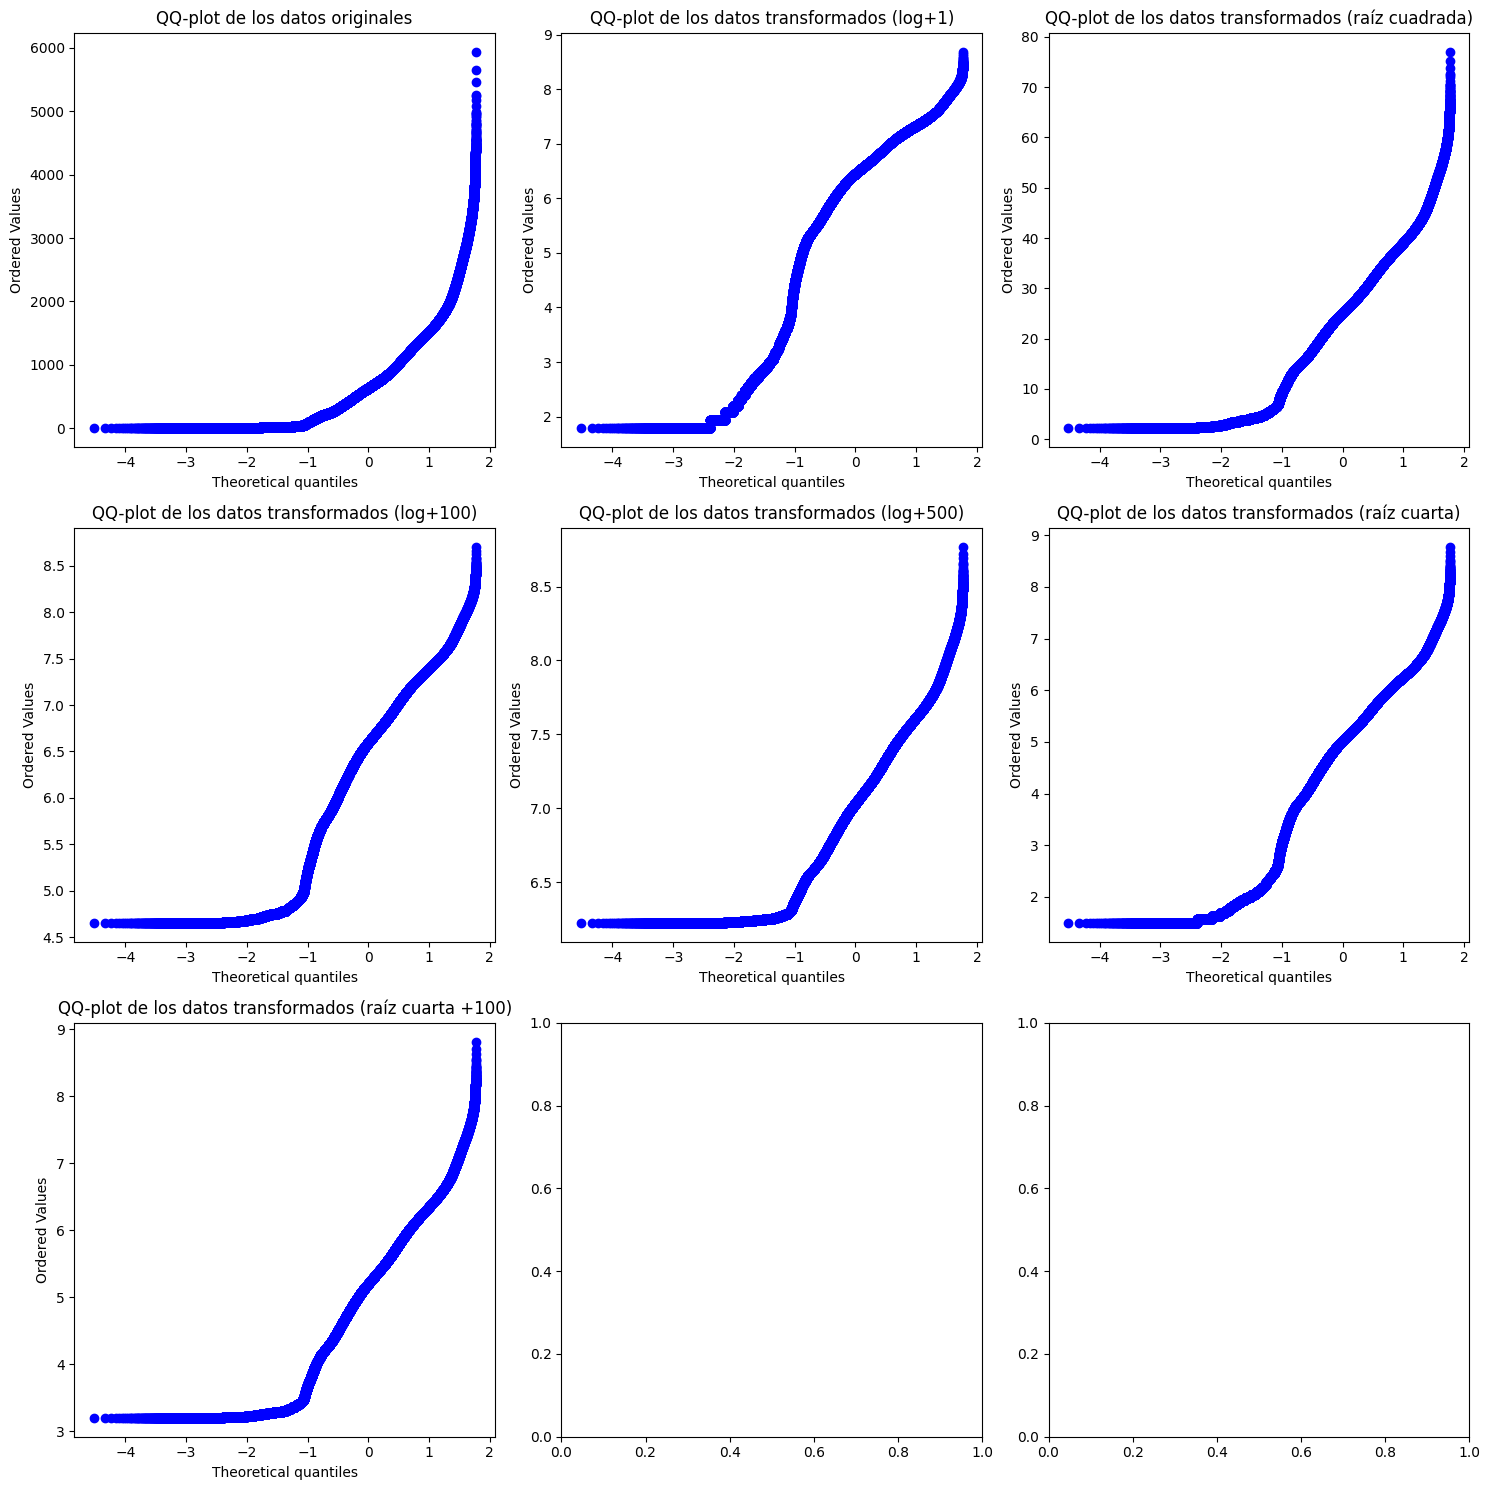

In [ ]:
#haremos un Q-Q plot de num_sold asi como probar con varias transformaciones para ver cual se asemeja mas a una normal
import matplotlib.pyplot as plt
import scipy.stats as stats
# Transformaciones (puedes agregar más)
log1_sales = np.log1p(train_prepared['num_sold'])
sqrt_sales = np.sqrt(train_prepared['num_sold'])
log100_sales = np.log(100+ train_prepared['num_sold'])
log500_sales = np.log(500+ train_prepared['num_sold'])
sqrt4_sales = (train_prepared['num_sold'])**(1/4)
sqrt100_sales = (train_prepared['num_sold']+100)**(1/4)
#box_cox_sales, _ = stats.boxcox(train_prepared['num_sold'])
# Crear subplots para comparar diferentes transformaciones
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# QQ-plot para los datos originales
# Access the correct subplot using axes[row, col]
stats.probplot(train_prepared['num_sold'], dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("QQ-plot de los datos originales")

# QQ-plot para los datos transformados logarítmicamente +1
stats.probplot(log1_sales, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("QQ-plot de los datos transformados (log+1)")

# QQ-plot para los datos transformados con raíz cuadrada
stats.probplot(sqrt_sales, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title("QQ-plot de los datos transformados (raíz cuadrada)")

# QQ-plot para los datos transformados log +100
stats.probplot(log100_sales, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("QQ-plot de los datos transformados (log+100)")

#QQ-plot para los datos transformados log+500
stats.probplot(log500_sales, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("QQ-plot de los datos transformados (log+500)")

stats.probplot(sqrt4_sales, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title("QQ-plot de los datos transformados (raíz cuarta)")

stats.probplot(sqrt100_sales, dist="norm", plot=axes[2, 0])
axes[2, 0].set_title("QQ-plot de los datos transformados (raíz cuarta +100)")

#stats.probplot(box_cox_sales, dist="norm", plot=axes[2, 1])
#axes[2, 1].set_title("QQ-plot de los datos transformados (Box-Cox)")


plt.tight_layout()
plt.show()

#terminamos el encoding de las variables, ahora pasaremos al tratamiento de los de NaN como primera opcion sera eliminarlos, *queda pendiente tratar de rellenarlos de alguna forma como con otro modelo especifico de la tienda en la que se realizo el registro

In [ ]:
#hacer otro dataframe de data_prepared pero sin los NaN
train_prepared_no_nan = train_prepared.dropna()
test_prepared_no_nan = test_prepared.dropna()

<Axes: xlabel='num_sold', ylabel='Count'>

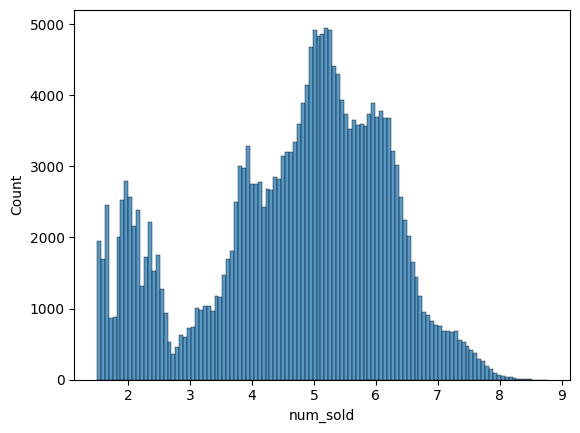

In [ ]:
#histograma de num_sold
sns.histplot(sqrt4_sales)

In [ ]:
#agregar sqrt4_num sold a train_sin_outliers
train_prepared['sqrt4_num_sold'] = sqrt4_sales

In [ ]:
#quitar los NaN de train prepared
train_prepared = train_prepared.dropna()

#MODELO

In [ ]:
train_prepared.columns

Index(['num_sold', 'PIB_per_capita', 'es_semana_de_ano_nuevo', 'is_ca_holiday',
       'is_fi_holiday', 'is_it_holiday', 'is_ke_holiday', 'is_no_holiday',
       'is_sg_holiday', 'dia_semana', 'mes', 'es_finde', 'trimestre', 'year',
       'country_Canada', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Discount Stickers',
       'store_Premium Sticker Mart', 'store_Stickers for Less',
       'product_Holographic Goose', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'sqrt4_num_sold'],
      dtype='object')

In [ ]:
#dividimos nuestro train_prepared en cada tipo de producto
train_prepared_H = train_prepared[train_prepared['product_Holographic Goose'] == 1]
train_prepared_H.drop('product_Holographic Goose', axis=1, inplace=True)
train_prepared_K = train_prepared[train_prepared['product_Kaggle'] == 1]
train_prepared_K.drop('product_Kaggle', axis=1, inplace=True)
train_prepared_KT = train_prepared[train_prepared['product_Kaggle Tiers'] == 1]
train_prepared_KT.drop('product_Kaggle Tiers', axis=1, inplace=True)
train_prepared_Ke = train_prepared[train_prepared['product_Kerneler'] == 1]
train_prepared_Ke.drop('product_Kerneler', axis=1, inplace=True)
train_prepared_KDM = train_prepared[train_prepared['product_Kerneler Dark Mode'] == 1]
train_prepared_KDM.drop('product_Kerneler Dark Mode', axis=1, inplace=True)


In [ ]:
#haremos un modelo para tipo de producto
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
X_1 = train_prepared_H.iloc[:, 1:-1]
y_1 = train_prepared_H.iloc[:, -1]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_2 = train_prepared_K.iloc[:, 1:-1]
y_2 = train_prepared_K.iloc[:, -1]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
X_3 = train_prepared_KT.iloc[:, 1:-1]
y_3 = train_prepared_KT.iloc[:, -1]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)
X_4 = train_prepared_Ke.iloc[:, 1:-1]
y_4 = train_prepared_Ke.iloc[:, -1]
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=42)
X_5 = train_prepared_KDM.iloc[:, 1:-1]
y_5 = train_prepared_KDM.iloc[:, -1]
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)

modelxgb_1 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7)
modelxgb_1.fit(X_train_1, y_train_1)
y_pred_1 = modelxgb_1.predict(X_test_1)
mape_1 = mean_absolute_percentage_error(y_test_1**4, y_pred_1**4)
print(f"MAPE: {mape_1}")

modelxgb_2 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7)
modelxgb_2.fit(X_train_2, y_train_2)
y_pred_2 = modelxgb_2.predict(X_test_2)
mape_2 = mean_absolute_percentage_error(y_test_2**4, y_pred_2**4)
print(f"MAPE: {mape_2}")

modelxgb_3 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7)
modelxgb_3.fit(X_train_3, y_train_3)
y_pred_3 = modelxgb_3.predict(X_test_3)
mape_3 = mean_absolute_percentage_error(y_test_3**4, y_pred_3**4)
print(f"MAPE: {mape_3}")

modelxgb_4 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7)
modelxgb_4.fit(X_train_4, y_train_4)
y_pred_4 = modelxgb_4.predict(X_test_4)
mape_4 = mean_absolute_percentage_error(y_test_4**4, y_pred_4**4)
print(f"MAPE: {mape_4}")

modelxgb_5 = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7)
modelxgb_5.fit(X_train_5, y_train_5)
y_pred_5 = modelxgb_5.predict(X_test_5)
mape_5 = mean_absolute_percentage_error(y_test_5**4, y_pred_5**4)
print(f"MAPE: {mape_5}")

MAPE: 0.04853547802613937
MAPE: 0.04675689358866273
MAPE: 0.04617960213396239
MAPE: 0.04893142645271879
MAPE: 0.04960442372639786


In [ ]:
#lo mismo que arriba solo que con lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
modelgbm_1 = lgb.LGBMRegressor()
modelgbm_1.fit(X_train_1, y_train_1)
y_pred_1 = modelgbm_1.predict(X_test_1)
mape_1 = mean_absolute_percentage_error(y_test_1**4, y_pred_1**4)
print(f"MAPE: {mape_1}")

modelgbm_2 = lgb.LGBMRegressor()
modelgbm_2.fit(X_train_2, y_train_2)
y_pred_2 = modelgbm_2.predict(X_test_2)
mape_2 = mean_absolute_percentage_error(y_test_2**4, y_pred_2**4)
print(f"MAPE: {mape_2}")

modelgb_3 = lgb.LGBMRegressor()
modelgb_3.fit(X_train_3, y_train_3)
y_pred_3 = modelgb_3.predict(X_test_3)
mape_3 = mean_absolute_percentage_error(y_test_3**4, y_pred_3**4)
print(f"MAPE: {mape_3}")

modelgbm_4 = lgb.LGBMRegressor()
modelgbm_4.fit(X_train_4, y_train_4)
y_pred_4 = modelgbm_4.predict(X_test_4)
mape_4 = mean_absolute_percentage_error(y_test_4**4, y_pred_4**4)
print(f"MAPE: {mape_4}")

modelgbm_5 = lgb.LGBMRegressor()
modelgbm_5.fit(X_train_5, y_train_5)
y_pred_5 = modelgbm_5.predict(X_test_5)
mape_5 = mean_absolute_percentage_error(y_test_5**4, y_pred_5**4)
print(f"MAPE: {mape_5}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 29776, number of used features: 22
[LightGBM] [Info] Start training from score 3.556754
MAPE: 0.04877024338539755
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 36820, number of used features: 22
[LightGBM] [Info] Start training from score 5.435356
MAPE

In [ ]:
#drop id de test_prepared
test_prepared.drop('id', axis=1, inplace=True)

In [ ]:
#dividimos de la misma manera nuestro test_prepared
test_prepared_H = test_prepared[test_prepared['product_Holographic Goose'] == 1]
test_prepared_H.drop('product_Holographic Goose', axis=1, inplace=True)
test_prepared_K = test_prepared[test_prepared['product_Kaggle'] == 1]
test_prepared_K.drop('product_Kaggle', axis=1, inplace=True)
test_prepared_KT = test_prepared[test_prepared['product_Kaggle Tiers'] == 1]
test_prepared_KT.drop('product_Kaggle Tiers', axis=1, inplace=True)
test_prepared_Ke = test_prepared[test_prepared['product_Kerneler'] == 1]
test_prepared_Ke.drop('product_Kerneler', axis=1, inplace=True)
test_prepared_KDM = test_prepared[test_prepared['product_Kerneler Dark Mode'] == 1]
test_prepared_KDM.drop('product_Kerneler Dark Mode', axis=1, inplace=True)

In [ ]:
#hacemos las predcciones de cada division
test_preds_H = (modelxgb_1.predict(test_prepared_H))**4
test_preds_K = (modelxgb_2.predict(test_prepared_K))**4
test_preds_KT = (modelxgb_3.predict(test_prepared_KT))**4
test_preds_Ke = (modelxgb_4.predict(test_prepared_Ke))**4
test_preds_KDM = (modelxgb_5.predict(test_prepared_KDM))**4

In [ ]:
#ahora con gbm
test_preds_H = (modelgbm_1.predict(test_prepared_H))**4
test_preds_K = (modelgbm_2.predict(test_prepared_K))**4
test_preds_KT = (modelgb_3.predict(test_prepared_KT))**4
test_preds_Ke = (modelgbm_4.predict(test_prepared_Ke))**4
test_preds_KDM = (modelgbm_5.predict(test_prepared_KDM))**4

In [ ]:
#sacar el index de test_prepared por producto y aplicarselo a las predicciones
inedx_H = test_prepared[test_prepared['product_Holographic Goose'] == 1].index
inedx_K = test_prepared[test_prepared['product_Kaggle'] == 1].index
inedx_KT = test_prepared[test_prepared['product_Kaggle Tiers'] == 1].index
inedx_Ke = test_prepared[test_prepared['product_Kerneler'] == 1].index
inedx_KDM = test_prepared[test_prepared['product_Kerneler Dark Mode'] == 1].index
#utilizar el index de cada producto para hacer un df con las predicciones y cada indice
test_preds_H = pd.DataFrame(test_preds_H, columns=['num_sold'])
test_preds_H.index = inedx_H
test_preds_K = pd.DataFrame(test_preds_K, columns=['num_sold'])
test_preds_K.index = inedx_K
test_preds_KT = pd.DataFrame(test_preds_KT, columns=['num_sold'])
test_preds_KT.index = inedx_KT
test_preds_Ke = pd.DataFrame(test_preds_Ke, columns=['num_sold'])
test_preds_Ke.index = inedx_Ke
test_preds_KDM = pd.DataFrame(test_preds_KDM, columns=['num_sold'])
test_preds_KDM.index = inedx_KDM
#juntar todas las predicciones en orden del indice
test_preds1 = pd.concat([test_preds_H, test_preds_K, test_preds_KT, test_preds_Ke, test_preds_KDM])

In [ ]:
#ordenar por index test_preds 1
test_preds1 = test_preds1.sort_index()

In [ ]:
#solo quedarnos con las predicciones de test_preds1
test_preds1 = test_preds1['num_sold']

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
MAPE: 0.06919344978183092

ya tenemos los parametros

In [ ]:
test.shape

(98550, 17)

In [ ]:
test_preds1.shape

(98550,)

In [ ]:
#extraer el id de test y concatenar las test_preds1
test_id = test['id']
test_preds1 = pd.DataFrame(test_preds1, columns=['num_sold'])
test_preds1 = pd.concat([test_id, test_preds1], axis=1)

In [ ]:
test_preds1.head()

id    num_sold
0  230130  130.646164
1  230131  878.223694
2  230132  713.606079
3  230133  397.589813
4  230134  457.494293

In [ ]:
train_prepared.head()

num_sold  PIB_per_capita  es_semana_de_ano_nuevo  is_ca_holiday  \
1     973.0       10.769761                       1              1   
2     906.0       10.769761                       1              1   
3     423.0       10.769761                       1              1   
4     491.0       10.769761                       1              1   
5     300.0       10.769761                       1              1   

   is_fi_holiday  is_it_holiday  is_ke_holiday  is_no_holiday  is_sg_holiday  \
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   
5              0              0              0              0              0   

   dia_semana  ...  country_Singapore  store_Discount Stickers  \
1           4  ...                0.0                      1.0   
2           4  ...                0.0                      1.0   
3           4  ...                0.0                      1.0   
4           4  ...                0.0                      1.0   
5           4  ...                0.0                      0.0   

   store_Premium Sticker Mart  store_Stickers for Less  \
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   
5                         0.0                      1.0   

   product_Holographic Goose  product_Kaggle  product_Kaggle Tiers  \
1                        0.0             1.0                   0.0   
2                        0.0             0.0                   1.0   
3                        0.0             0.0                   0.0   
4                        0.0             0.0                   0.0   
5                        1.0             0.0                   0.0   

   product_Kerneler  product_Kerneler Dark Mode  sqrt4_num_sold  
1               0.0                         0.0        5.585065  
2               0.0                         0.0        5.486332  
3               1.0                         0.0        4.535081  
4               0.0                         1.0        4.707284  
5               0.0                         0.0        4.161791  

[5 rows x 29 columns]

In [ ]:
#agregar num_sold de test_preds1 a test_prepared como la primera columna
test_prepared.insert(0, 'num_sold', test_preds1['num_sold'])
test_prepared.head()

num_sold  PIB_per_capita  es_semana_de_ano_nuevo  is_ca_holiday  \
0  130.646164       10.717294                       1              1   
1  878.223694       10.717294                       1              1   
2  713.606079       10.717294                       1              1   
3  397.589813       10.717294                       1              1   
4  457.494293       10.717294                       1              1   

   is_fi_holiday  is_it_holiday  is_ke_holiday  is_no_holiday  is_sg_holiday  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   dia_semana  ...  country_Norway  country_Singapore  \
0           6  ...             0.0                0.0   
1           6  ...             0.0                0.0   
2           6  ...             0.0                0.0   
3           6  ...             0.0                0.0   
4           6  ...             0.0                0.0   

   store_Discount Stickers  store_Premium Sticker Mart  \
0                      1.0                         0.0   
1                      1.0                         0.0   
2                      1.0                         0.0   
3                      1.0                         0.0   
4                      1.0                         0.0   

   store_Stickers for Less  product_Holographic Goose  product_Kaggle  \
0                      0.0                        1.0             0.0   
1                      0.0                        0.0             1.0   
2                      0.0                        0.0             0.0   
3                      0.0                        0.0             0.0   
4                      0.0                        0.0             0.0   

   product_Kaggle Tiers  product_Kerneler  product_Kerneler Dark Mode  
0                   0.0               0.0                         0.0  
1                   0.0               0.0                         0.0  
2                   1.0               0.0                         0.0  
3                   0.0               1.0                         0.0  
4                   0.0               0.0                         1.0  

[5 rows x 28 columns]

In [ ]:
#guardad como csv test_preds1
test_preds1.to_csv('test_preds11.csv', index=False)

In [ ]:
#juntar train_prepared con test_prepared
all_data = pd.concat([train_prepared, test_prepared])

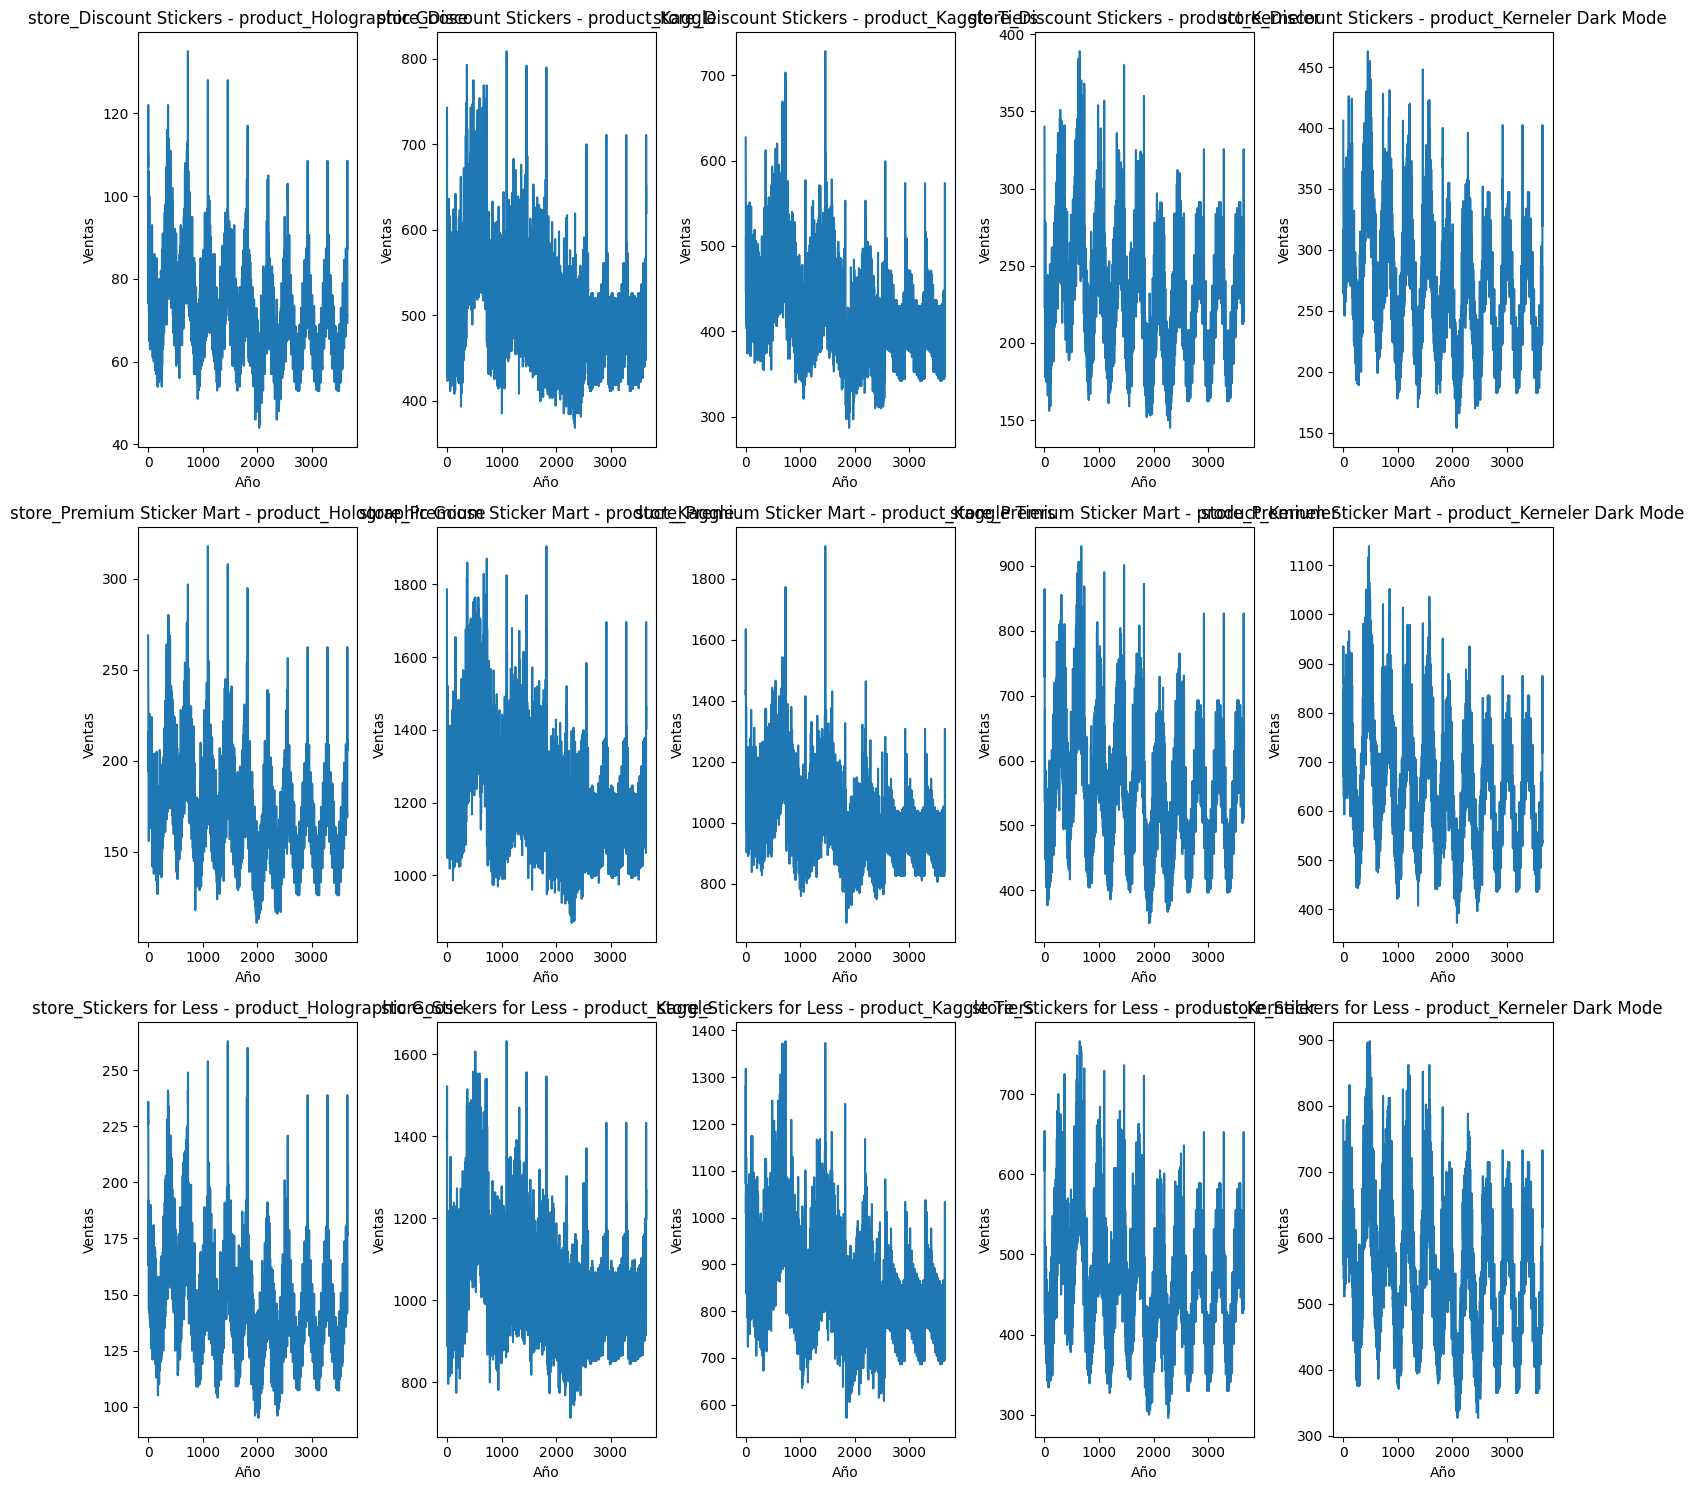

In [ ]:
# Obtén la lista de nombres de columnas
columnas = all_data.columns

# Define los rangos de índices para las columnas de tienda y producto
indice_tienda_inicio = columnas.get_loc('store_Discount Stickers')
indice_tienda_fin = indice_tienda_inicio + 3  # 3 columnas de tienda
indice_producto_inicio = columnas.get_loc('product_Holographic Goose')
indice_producto_fin = indice_producto_inicio + 5  # 5 columnas de producto

# Crea una figura con 15 subgráficos
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15))

# Itera sobre las columnas de tienda y producto
indice_grafico = 0
for i in range(indice_tienda_inicio, indice_tienda_fin):
    for j in range(indice_producto_inicio, indice_producto_fin):
        # Filtra el DataFrame
        filtro = (
            (all_data['country_Italy'] == 1)
            & (all_data[columnas[i]] == 1)
            & (all_data[columnas[j]] == 1)
        )
        df_filtrado = all_data[filtro]

        # Calcula la posición del subgráfico
        fila = indice_grafico // 5
        columna = indice_grafico % 5

        # Grafica los datos de ventas en función del año
        axes[fila, columna].plot(df_filtrado['num_sold'].values)

        # Configura el título y las etiquetas del subgráfico
        axes[fila, columna].set_title(f'{columnas[i]} - {columnas[j]}')
        axes[fila, columna].set_xlabel('Año')
        axes[fila, columna].set_ylabel('Ventas')

        indice_grafico += 1

# Ajusta el diseño de los subgráficos para evitar superposiciones
plt.tight_layout()